# Uncertainty Quantification in Language Models


## Introduction & Objective

This project explores methods for **uncertainty quantification (UQ)** in large language models, with a focus on both **token-level** and **sentence-level** signals. Instead of treating model predictions as binary outcomes, we measure the model’s *confidence* and *uncertainty* throughout the generation process.

Key aspects:
- **Token-level signals:** entropy, probability margins, chosen-token probability.
- **Sentence-level signals:** geometric mean confidence, mean entropy, variance of log-probabilities.
- **Calibration:** reliability diagrams, Expected Calibration Error (ECE), Brier score, AUROC, and risk–coverage curves.

The backbone model is **Phi-3-Mini-4k-Instruct** (4-bit quantized), chosen for its efficiency and accessibility while still providing token-level probabilities. Experiments were conducted locally on a single GPU (RTX 2070, 8GB VRAM), enabling systematic evaluation across both **math reasoning** and **factual QA**.

This project demonstrates how uncertainty metrics can reveal when a model’s outputs are trustworthy, and highlights how effectiveness varies dramatically between reasoning and knowledge-recall tasks.


In [4]:
import numpy as np
import pandas as pd
import os
import re
import math
import torch.nn.functional as F
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import json
import time
from sklearn.metrics import roc_auc_score
import transformers
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from datasets import load_dataset    
from IPython.display import HTML, display

In [5]:
# Download and load model 


model_name= "microsoft/Phi-3-mini-4k-instruct"

# tokenizer
tok=AutoTokenizer.from_pretrained(model_name, use_fast=True)
if tok.pad_token is None:
    tok.pad_token=tok.eos_token 

# 4-bit quantization for running locally on limited GPU
bnb_cfg= BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

# model
model= AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_cfg,
    device_map="auto",                 
    torch_dtype=torch.float16,
    max_memory={0: "6GiB", "cpu": "16GiB"},  
    low_cpu_mem_usage=True,
)

print("Loaded:", model_name)
print("Model dtype:", next(model.parameters()).dtype)
print("Device map:", getattr(model, "hf_device_map", "n/a"))

Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.78s/it]


Loaded: microsoft/Phi-3-mini-4k-instruct
Model dtype: torch.float16
Device map: {'': 0}



## Datasets

Two complementary datasets were selected to evaluate uncertainty quantification across distinct task types:

- **GSM8K (math reasoning)**  
  - A benchmark of grade-school math word problems requiring multi-step reasoning and numeric answers  
  - Suitable for testing whether uncertainty signals capture reasoning bottlenecks, propagation of error across steps, and calibration under structured problem solving  
  - Outputs are deterministic and numeric, making accuracy evaluation straightforward and selective prediction strategies (risk–coverage) meaningful  

- **TriviaQA (factual QA)**  
  - A large-scale factual question answering dataset with short, entity-style answers  
  - Provides a contrast to GSM8K by focusing on knowledge recall rather than stepwise reasoning  
  - Useful for analyzing calibration in span-style answers, and for testing whether uncertainty can separate correct vs incorrect factual outputs even when answers are brief and phrasing varies  

Together, GSM8K and TriviaQA offer **complementary coverage**: reasoning-heavy vs knowledge-retrieval tasks, numeric outputs vs natural language spans. This dual setup helps assess how well uncertainty estimation methods generalize across different task families.


### Dataset load and sanity check 

In [6]:
#Sanity check with gsm8k dataset
gsm=load_dataset("gsm8k", "main", split="test[:500]") 
print("Loaded items:", len(gsm))

ex=gsm[0]
print("\nQuestion:\n",ex["question"])
print("\nMain Answer (after '####'):\n", ex["answer"].split("####")[-1].strip())

Loaded items: 500

Question:
 Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?

Main Answer (after '####'):
 18


In [7]:
@torch.no_grad()
def test_gsm(ex,system=None,max_new_tokens=64):
    q = ex["question"].strip()
    msgs = []
    if system is not None:
        msgs.append({"role": "system", "content": system})
    msgs.append({"role": "user", "content": q})
    prompt=tok.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
    inp=tok(prompt, return_tensors="pt").to(model.device)
    out=model.generate(
        **inp,
        max_new_tokens=max_new_tokens,
        do_sample=False, # Deterministic results
        pad_token_id=tok.pad_token_id,
        return_dict_in_generate=True,
        output_scores=True,
        use_cache=True
    )
    gen_ids=out.sequences[0, inp.input_ids.shape[1]:]
    pred_text= tok.decode(gen_ids, skip_special_tokens=True).strip()
    chosen_lp= []
    for t, logits in enumerate(out.scores): 
        tok_id=gen_ids[t].item()
        if tok_id==tok.eos_token_id:
            break
        lp=F.log_softmax(logits[0], dim=-1)[tok_id].item() # calculate log probs from logits 
        chosen_lp.append(lp)

    conf= math.exp(sum(chosen_lp)/len(chosen_lp)) if chosen_lp else 0.0 # model confidence/geometric mean of token probabilities
    return pred_text,conf

system='Be concise.'
ex=gsm[0]

out,conf=test_gsm(ex,system,max_new_tokens=128)    
print("Answer provided by LLM:"+ out)
print("\nModel confidence score: ",conf)

You are not running the flash-attention implementation, expect numerical differences.


Answer provided by LLM:Janet's ducks lay 16 eggs per day.
She eats 3 eggs for breakfast and bakes muffins with 4 eggs.
So, the number of eggs she sells at the farmers' market is 16 - 3 - 4 = 9 eggs.
She sells each egg for $2, so she makes 9 * $2 = $18 every day at the farmers' market.

Model confidence score:  0.932809522228658


In [8]:
# Attempt to tell the LLM to output the final result only
system = ( "You are a careful math solver. Consider the given question and compute internally but DO NOT show steps.\n"
                 "OUTPUT EXACTLY: ANSWER: <number>\n" 
                 "No extra words, symbols, commas, or units." )
res,conf=test_gsm(ex,system,max_new_tokens=128)    
print("Answer provided by LLM:"+ res)
print("\nModel confidence score: ",conf)

Answer provided by LLM:13

Model confidence score:  0.3614117743393964


It seems that if the model is forced to tighten its response to only the final result, it starts to hallucinate and drift. This has been tested with many variation of the prompts. Unless the model is allowed to generate the full reasoning sequence, it often produces incorrect answers.

On the other hand, depending on how long the answer is, it can potentially run into out-of-memory issues. To address this, we shall use chunk wise generation. Prompts are provided in tokenized form so that generated chunks remain as coherent as possible.

A greedy decoding approach is adopted to produce deterministic outputs.

For obtaining concrete value of the solution, the prompt has been set to instruct the model to output the following at the end - 

FINAL: ANSWER

END

When this format is detected, chunk generation is stopped early, as the model otherwise tends to produce unwanted trailing tokens.

#### Uncertainty estimation methods

The framework collects both token-level and sentence-level signals from the model’s generation:

- Token-level signals
  - Token entropy: uncertainty per token 
  - Max token entropy: largest spike of uncertainty, with its position
  - Min token margin: lowest difference between top-1 and top-2 token probabilities, with position
  - Min chosen probability: least confident token in the sequence, with position

- Sentence-level signals
  - Confidence: geometric mean of chosen token probabilities (sequence-level score)
  - Std log-prob: variability of token log-probabilities across the whole sequence
  - Mean token entropy: average uncertainty per token across the sequence
  - Std log-prob (last-k): variability restricted to the final k tokens, capturing answer endings



In [9]:
_num_re=re.compile(r"[-+]?(?:(?:\d{1,3}(?:,\d{3})+)|\d+)(?:\.\d+)?(?:[eE][-+]?\d+)?") #detect number from text
_final_re= re.compile(r'(?m)^\s*FINAL:\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\s*$') # detect FINAL in text
_end_re= re.compile(r"(?m)^\s*END\s*$") # detect END in text
def extract_last_number(s: str):
    "Extract the last number/value from the text"
    if not s:
        return None
    last= None
    for m in _num_re.finditer(s):
        last= m.group(0)
    return last

#convert value to float for comparison
def _to_float(s: str | None): 
    if s is None: 
        return None
    try:
        return float(s.replace(",", ""))
    except Exception:
        return None

In [10]:

@torch.no_grad()
def generate_response(ex,data_type='math',system=None,chunk_size=128,max_total_new=512,debug=False):
    q=ex["question"].strip()
    msgs= []
    if system is not None:
        msgs.append({"role": "system", "content": system})
    msgs.append({"role": "user", "content": q})


    prompt_text=tok.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
    
    # use tokenized prompt so chunks remain as coherent as possible
    enc= tok(prompt_text, return_tensors="pt")
    prompt_ids= enc.input_ids.to(model.device)      
    attn_mask =enc.attention_mask.to(model.device) 

    n_prompt_tokens=int(prompt_ids.shape[1])
    total_new= 0
    all_gen_ids= []  

    
    chosen_lp=[]          # log p(yt)
    entropies= []          # entropy
    margins=[]            # p(top1)-p(top2) / margin of token selection
    min_margin= None  
    min_margin_pos=None
    max_entropy= None
    max_entropy_pos=None
    min_chosen_prob =None
    min_chosen_prob_pos=None
    
    gen_buffer=''
    seen_final=False
    post_final_token_cap=40
    if debug:
        chunk_num=1
    while total_new < max_total_new:
        
        out=model.generate(
            input_ids=prompt_ids,
            attention_mask=attn_mask,
            max_new_tokens=min(chunk_size, max_total_new - total_new),
            do_sample=False, # deterministic/greedy based approach
            pad_token_id=tok.pad_token_id,
            return_dict_in_generate=True,
            output_scores=True,
            use_cache=True,
        )
       
            

        full=out.sequences                          
        new_len=full.shape[1] - prompt_ids.shape[1]
        if new_len<=0:
            break

        new_ids=full[:, -new_len:]                   
        all_gen_ids.extend(new_ids[0].tolist())
        total_new += int(new_len)
        
       

        # Chunk wise statistics
        for t, logits in enumerate(out.scores):
            tid=new_ids[0, t].item()
            if tid == tok.eos_token_id:
                break  
            logp=F.log_softmax(logits[0], dim=-1)
            p=logp.exp()

            c_lp=float(logp[tid].item())
            chosen_lp.append(c_lp)

            H=float(-(p * logp).sum().item())
            entropies.append(H)

            top2, _=torch.topk(p, k=2)
            margin=float(top2[0].item() - top2[1].item())
            margins.append(margin)

            pos=len(entropies) - 1
            if (max_entropy is None) or (H > max_entropy):
                max_entropy, max_entropy_pos=H, pos
            if (min_margin is None) or (margin < min_margin):
                min_margin, min_margin_pos=margin, pos
            cp=float(p[tid].item())
            if (min_chosen_prob is None) or (cp < min_chosen_prob):
                min_chosen_prob, min_chosen_prob_pos=cp, pos
        
        # decode the generated output.  
        tail_text=tok.decode(new_ids[0], skip_special_tokens=True)
        if debug:
            print("Chunk "+str(chunk_num)+': '+tail_text)
            chunk_num+=1
        '''
        For the gsm dataset, the prompt states to end with "FINAL: <number>\nEND". 
        If such a case is found the chunk generation is stopped below. Otherwise the model produces unwanted tokens.
        '''
        if data_type=='math':
            gen_buffer=(gen_buffer + tail_text)[-256:] # prevent the buffer from becoming too large  
            final_=_final_re.search(gen_buffer)   
            if final_:
                seen_final=True
                tokens_after_final=0
                post_final=gen_buffer[final_.end():]
                if _end_re.search(post_final):   
                    break
            
            if not seen_final:
                if _final_re.search(gen_buffer):
                    seen_final=True
                    tokens_after_final=0
                    
                
            else:
                tokens_after_final += int(new_len)
                if _end_re.search(gen_buffer) or tokens_after_final >= post_final_token_cap:
                    break
        else:
            # for triviaQA dataset, the answers are generally short and chunk generation is not necessary
            break 

        # append generated tokens to prompt for chunk wise generation consistency
        prompt_ids=torch.cat([prompt_ids, new_ids], dim=1)
        attn_mask =torch.ones_like(prompt_ids, device=prompt_ids.device)

      

    # decode generated text
    gen_text=tok.decode(torch.tensor(all_gen_ids, device=model.device), skip_special_tokens=True) if all_gen_ids else ""

    # geometric mean of token probabilities
    conf=math.exp(sum(chosen_lp)/len(chosen_lp)) if chosen_lp else None
    mean_token_entropy=float(np.mean(entropies)) if entropies else None
    
    # Standard deviation of the chosen token log-probs
    std_logp=None
    std_logp_last_k=None
    if chosen_lp:
        lp=np.asarray(chosen_lp, dtype=float)
        std_logp=float(lp.std())

        
        K=10 if data_type=='math' else 5
        K=min(K, len(lp))
        std_logp_last_k=float(lp[-K:].std())

    return {
        "confidence": conf,
        "mean_token_entropy":mean_token_entropy,
        "max_token_entropy": float(max_entropy) if max_entropy is not None else None,
        "argmax_token_entropy":int(max_entropy_pos) if max_entropy_pos is not None else None,
        "min_token_margin": float(min_margin) if min_margin is not None else None,
        "argmin_token_margin": int(min_margin_pos) if min_margin_pos is not None else None,
        "min_chosen_prob":float(min_chosen_prob) if min_chosen_prob is not None else None,
        "argmin_chosen_prob": int(min_chosen_prob_pos) if min_chosen_prob_pos is not None else None,
        "std_logp": std_logp,
        "std_logp_last_k": std_logp_last_k,
        "n_prompt_tokens": n_prompt_tokens,
        "n_gen_tokens": total_new,
        "gen_text": gen_text,
    }
    
    

## GSM8K Dataset

In [11]:
def gsm8k_output_parser(ex, gen_text, atol: float=1e-9):
    threshold=1e-9 # accounting for floating point precision 
    text=gen_text or ""

    #  pick the last "FINAL" statement as provided in the prompt
    last_final=None
    for m in _final_re.finditer(text):
        last_final=m
        
    pred_str=last_final.group(1) if last_final else extract_last_number(text)

    
    gold_tail=ex["answer"].split("####")[-1].strip()
    gold_str =extract_last_number(gold_tail)

    
    pred_num=_to_float(pred_str)
    gold_num=_to_float(gold_str)
    correct=(pred_num is not None and gold_num is not None and abs(pred_num - gold_num) < threshold)
    return gold_num, pred_num, bool(correct)

In [12]:
def gsm8k_eval(dataset, n=5, system=None,seed=42,chunk_size=128, max_total_new=512):

    rng=np.random.default_rng(seed)
    idxs=rng.permutation(len(dataset))[:n]

    rows=[]
    for i, idx in enumerate(idxs, 1):
        ex=dataset[int(idx)]
        out=generate_response(ex, data_type='math',system=system,chunk_size=chunk_size, max_total_new=max_total_new)
        gold_num, pred_num, correct=gsm8k_output_parser(ex,out['gen_text'])
        row={
            "id": int(idx),
            "question": ex["question"],
            "gold_num": gold_num,
            "pred_num": pred_num,
            "correct": int(correct),
            "confidence": out["confidence"],
            "mean_token_entropy": out["mean_token_entropy"],
            "max_token_entropy": out["max_token_entropy"],
            "argmax_token_entropy": out["argmax_token_entropy"],
            "min_token_margin": out["min_token_margin"],
            "argmin_token_margin": out["argmin_token_margin"],
            "min_chosen_prob": out["min_chosen_prob"],
            "argmin_chosen_prob": out["argmin_chosen_prob"],
            "std_logp":out["std_logp"],
            "std_logp_last_k": out["std_logp_last_k"],
            "n_prompt_tokens": out["n_prompt_tokens"],
            "n_gen_tokens": out["n_gen_tokens"],
            "gen_text": out["gen_text"],
        }
        rows.append(row)
        if i % 10 == 0:
            print(f"[{i}/{len(idxs)}] done")

    df=pd.DataFrame(rows)

    
    return df

system=(
    "You are a careful math solver. Be concise in your output.\n"
    "Let NUMBER be the numeric value of the quantity the question asks for (no units or symbols).\n"
    "Print the resulting number exactly in the format: FINAL: <NUMBER>\n"
    "Then on a new line write: END\n"
    "Do not output anything after END."
)
df_gsm=gsm8k_eval(gsm, n=200,system=system,seed=42)

#store in csv for easy access
run_id = time.strftime("%Y%m%d-%H%M%S")
gsm_csv_name=f'gsm8k_phi3_{run_id}.csv'
df_gsm.to_csv(gsm_csv_name,header=True,index=False)

[10/200] done
[20/200] done
[30/200] done
[40/200] done
[50/200] done
[60/200] done
[70/200] done
[80/200] done
[90/200] done
[100/200] done
[110/200] done
[120/200] done
[130/200] done
[140/200] done
[150/200] done
[160/200] done
[170/200] done
[180/200] done
[190/200] done
[200/200] done


In [13]:
# load GSM8K output from save file. 
df_gsm=pd.read_csv(gsm_csv_name)

'''  Please uncomment the following code block if pre-existing dataset is to be examined '''
# notebook_dir = os.path.dirname(os.path.abspath("__file__"))
# gsm_csv_path=os.path.join(notebook_dir,'output_csv','gsm8k_phi3_200.csv')
# try:
#     df_gsm=pd.read_csv(gsm_csv_path)
# except Exception as e:
#     print(f"Error reading {gsm_csv_path}: {e}")

'  Please uncomment the following code block if pre-existing dataset is to be examined '

In [14]:
df_gsm.head(3)

,id,question,gold_num,pred_num,correct,confidence,mean_token_entropy,max_token_entropy,argmax_token_entropy,min_token_margin,argmin_token_margin,min_chosen_prob,argmin_chosen_prob,std_logp,std_logp_last_k,n_prompt_tokens,n_gen_tokens,gen_text
0,473,Benny saw a 10-foot shark with 2 6-inch remora...,10.0,5.0,0,0.801284,0.540045,7.222034,64,0.005108,64,0.029878,64,0.535339,0.089089,120,165,"First, we need to convert the remoras' length ..."
1,132,Pam and Fred went to a carnival. Pam rode the ...,60.0,60.0,1,0.931763,0.162757,1.719448,18,0.033291,18,0.372010,18,0.184336,0.095266,138,151,Pam rode the roller coaster 2 times and the lu...
2,472,"Matt wants cookies for a snack, but his dad wa...",6.0,6.0,1,0.908359,0.225221,4.514759,123,0.002981,123,0.096891,123,0.252528,0.097291,147,204,Let's denote the number of carrot sticks Matt ...


### Dataset wise evaluation metrics


To assess the quality of uncertainty estimates, several complementary metrics were used:

- Accuracy: measures prediction correctness 
- Brier score: evaluates both accuracy and calibration; lower values are better  
- Expected Calibration Error (ECE): measures miscalibration by comparing confidence bins with observed accuracy  
- AUROC: evaluates how well uncertainty separates correct from incorrect predictions (errors as positives)  
- Risk–coverage (AURC): assesses selective prediction by measuring the trade-off between abstention and risk  

Together, these metrics capture **performance**, **calibration**, and **error ranking ability**, giving a comprehensive view of how useful the uncertainty signals are.


In [15]:
# brier score 
def brier(conf, labels):
    conf=np.asarray(conf, float)
    labels=np.asarray(labels, float)
    return float(np.mean((conf - labels)**2))

# expected calibration error
def ece(conf, labels, n_bins=10):
    conf=np.asarray(conf, float); labels=np.asarray(labels, float)
    bins=np.linspace(0.0, 1.0, n_bins+1)
    e=0.0; N=len(conf)
    for i in range(n_bins):
        if i == 0:
            mask=(conf >= bins[i]) & (conf <= bins[i+1])
        else:
            mask=(conf > bins[i]) & (conf <= bins[i+1])
        if not np.any(mask): 
            continue
        acc=float(np.mean(labels[mask]))
        avg_c=float(np.mean(conf[mask]))
        e += (np.sum(mask)/N) * abs(acc - avg_c)
    return float(e)

In [16]:
def calculate_metrics(df,method='confidence',label='correct'):
    
    
    mask=df[method].notnull()
    conf=df.loc[mask, method].astype(float).values
    labels=df.loc[mask, label].astype(float).values
    uncert=1.0 - conf

    if len(conf) >= 2:
        acc=float(labels.mean())
        br=brier(conf, labels)
        ec=ece(conf, labels, n_bins=10)
    
        y_err=1.0-labels
        auc=float(roc_auc_score(y_err, uncert)) if len(np.unique(y_err)) > 1 else float("nan")
    else:
        acc=br=ec=auc=float("nan")

    metrics=dict(accuracy=acc, brier=br, ece=ec, auroc=auc)

    return metrics

In [17]:
metrics=calculate_metrics(df_gsm,method='confidence')
print("Metric summary based on confidence -")
for i in metrics.keys():
    print(i,'score \t:',metrics[i])

Metric summary based on confidence -
accuracy score 	: 0.78
brier score 	: 0.16893730393419054
ece score 	: 0.11859787633942988
auroc score 	: 0.7517482517482518



GSM8K - Summary metrics with respect to model confidence

- Accuracy: 0.780; fairly strong for math based GSM8K, though not state-of-the-art
- Brier score: 0.169; reasonably low; indicates calibration is not terrible, but still room to improve
- ECE (10 bins): 0.119; moderate miscalibration; confidence is higher than actual accuracy
- AUROC (1 − confidence vs errors): 0.752; indicating that uncertainty signals can rank errors fairly well, though not at a perfect level

## Visualization and analysis

We generate a series of plots for both GSM8K (math reasoning) and TriviaQA (factual QA) to examine calibration, error separability, selective prediction, and feature-level patterns.  



In [18]:
# reliability diagram with respect to confidence
def plot_reliability_confidence(
    df, conf_col="confidence", label_col="correct", n_bins=10, 
    title="Reliability", save_path=None, save=True
):
    x = pd.to_numeric(df[conf_col], errors="coerce")
    y = pd.to_numeric(df[label_col], errors="coerce")
    mask = x.notnull() & y.notnull()
    x = x[mask].values
    y = y[mask].values
    if x.size == 0:
        print("No valid data for reliability plot")
        return None

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx = np.digitize(x, bins, right=True)

    bin_conf = []
    bin_acc = []
    counts = []

    for b in range(1, len(bins)):
        m = idx == b
        if not np.any(m):
            continue
        bin_conf.append(float(x[m].mean()))
        bin_acc.append(float(y[m].mean()))
        counts.append(int(m.sum()))

    bin_conf = np.asarray(bin_conf, dtype=float)
    bin_acc = np.asarray(bin_acc, dtype=float)
    counts = np.asarray(counts, dtype=int)

    if counts.sum() == 0:
        print("All bins empty")
        return None

    ece = float(np.sum((counts / counts.sum()) * np.abs(bin_acc - bin_conf)))

    fig = plt.figure(figsize=(6.5, 5.0))
    ax = fig.add_subplot(111)

    ax.plot([0.0, 1.0], [0.0, 1.0], linestyle="--", linewidth=1.0, color="gray", label="Ideal")
    ax.plot(bin_conf, bin_acc, marker="o", linewidth=2.0, label="Empirical")

    ax.set_xlabel("Mean confidence (per bin)")
    ax.set_ylabel("Accuracy (per bin)")
    ax.set_title(f"{title}  |  ECE={ece:.3f}")
    ax.legend(loc="upper left")

    ax2 = ax.twinx()
    ax2.bar(bin_conf, counts, width=0.06, alpha=0.25, color="tab:blue", label="Bin count")
    ax2.set_ylabel("Count")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    if save:
        if save_path is None:
            save_path = f"visualization/{title}.jpeg"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200)
        print(f"Figure saved to {save_path}")
    plt.show()

    print(f"Items used: {x.size}")
    print(f"ECE ({n_bins} bins): {ece:.4f}")
    return ece

In [19]:
# ROC 
def plot_roc_three(df, label_col="correct",title="Error Detection ROC", save_path=None, save=True):
    y = pd.to_numeric(df[label_col], errors="coerce").astype(float).values
    y_err = 1.0 - y

    u_conf = 1.0 - pd.to_numeric(df["confidence"], errors="coerce")
    u_std_tail = pd.to_numeric(df["std_logp"], errors="coerce")
    u_mean_ent = pd.to_numeric(df["mean_token_entropy"], errors="coerce")

    m = u_conf.notnull() & u_std_tail.notnull() & u_mean_ent.notnull() & np.isfinite(y_err)
    if m.sum() < 2 or np.unique(y_err[m]).size < 2:
        print("Not enough data to plot ROC")
        return

    fpr1, tpr1, _ = roc_curve(y_err[m], u_conf[m].values)
    fpr2, tpr2, _ = roc_curve(y_err[m], u_std_tail[m].values)
    fpr3, tpr3, _ = roc_curve(y_err[m], u_mean_ent[m].values)

    auc1 = auc(fpr1, tpr1)
    auc2 = auc(fpr2, tpr2)
    auc3 = auc(fpr3, tpr3)

    plt.figure(figsize=(6,5))
    plt.plot([0,1], [0,1], linestyle="--", color="gray", linewidth=1, label="Random")
    plt.plot(fpr1, tpr1, label=f"1 - confidence (AUC={auc1:.3f})")
    plt.plot(fpr2, tpr2, label=f"std_logp (AUC={auc2:.3f})")
    plt.plot(fpr3, tpr3, label=f"mean_token_entropy (AUC={auc3:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    if save:
        if save_path is None:
            save_path = f"visualization/{title}.jpeg"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200)
        print(f"Figure saved to {save_path}")
    plt.show()

    print(f"AUC 1 - confidence: {auc1:.3f}")
    print(f"AUC std_logp: {auc2:.3f}")
    print(f"AUC mean_token_entropy: {auc3:.3f}")

In [20]:
# ROC values per uncertainty methods
def auroc_bar_chart(df, label_col="correct",title="AUROC by uncertainty method", save_path=None, save=True):
    methods = {
        "1 - confidence": 1.0 - pd.to_numeric(df["confidence"], errors="coerce"),
        "mean_token_entropy": pd.to_numeric(df["mean_token_entropy"], errors="coerce"),
        "std_logp (global)": pd.to_numeric(df.get("std_logp"), errors="coerce"),
        "std_logp_last_k": pd.to_numeric(df.get("std_logp_last_k"), errors="coerce"),
        "max_token_entropy": pd.to_numeric(df.get("max_token_entropy"), errors="coerce"),
        "-min_token_margin": -pd.to_numeric(df.get("min_token_margin"), errors="coerce"),
        "1 - min_chosen_prob": 1.0 - pd.to_numeric(df.get("min_chosen_prob"), errors="coerce"),
    }

    y = pd.to_numeric(df[label_col], errors="coerce").astype(float).values
    y_err = 1.0 - y

    names = []
    aucs = []

    for name, series in methods.items():
        if series is None:
            continue
        m = series.notnull() & np.isfinite(y_err)
        if m.sum() < 2 or np.unique(y_err[m]).size < 2:
            continue
        auc = roc_auc_score(y_err[m], series[m].values)
        names.append(name)
        aucs.append(float(auc))

    if len(aucs) == 0:
        print("No AUROCs to plot")
        return

    order = np.argsort(aucs)[::-1]
    names_sorted = [names[i] for i in order]
    aucs_sorted = [aucs[i] for i in order]

    plt.figure(figsize=(7, 4.5))
    bars = plt.bar(range(len(names_sorted)), aucs_sorted, alpha=0.85)
    plt.xticks(range(len(names_sorted)), names_sorted, rotation=30, ha="right")
    plt.ylim(0.5, 1.0)
    plt.ylabel("AUROC (errors as positives)")
    plt.title(title)

    for i, v in enumerate(aucs_sorted):
        plt.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    if save:
        if save_path is None:
            save_path = f"visualization/{title}.jpeg"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200)
        print(f"Figure saved to {save_path}")
    plt.show()

In [21]:
# histogram and box plot by feature vs correctness
def plot_hist_and_box_by_correct(
    df,feature_col="mean_token_entropy",label_col="correct",bins=20, 
    title="Feature vs correctness", save_path=None, save=True
):
    d = df[[feature_col, label_col]].copy()
    d[feature_col] = pd.to_numeric(d[feature_col], errors="coerce")
    d[label_col] = pd.to_numeric(d[label_col], errors="coerce")
    d = d.dropna()
    if len(d) == 0:
        print("No data to plot")
        return

    ok = d[label_col].astype(int) == 1
    vals_ok = d.loc[ok, feature_col].values
    vals_ng = d.loc[~ok, feature_col].values

    edges = np.histogram_bin_edges(d[feature_col].values, bins=bins)

    fig = plt.figure(figsize=(6, 10))
    ax1 = fig.add_subplot(2, 1, 1)

    ax1.hist(vals_ok, bins=edges, alpha=0.6, label="correct")
    ax1.hist(vals_ng, bins=edges, alpha=0.6, label="incorrect")
    ax1.set_xlabel(feature_col)
    ax1.set_ylabel("count")
    ax1.set_title(title if title else f"{feature_col}: correct vs incorrect")
    ax1.legend()

    ax2 = fig.add_subplot(2, 1, 2)

    d_box = d[[label_col, feature_col]].copy()
    d_box[label_col] = d_box[label_col].astype(int)
    sns.boxplot(data=d_box, x=label_col, y=feature_col, ax=ax2)
    ax2.set_xlabel(f"{label_col} (0=wrong, 1=right)")
    ax2.set_ylabel(feature_col)
    ax2.set_title(f"{feature_col} by correctness")

    plt.tight_layout()
    if save:
        if save_path is None:
            save_path = f"visualization/{title}.jpeg"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200)
        print(f"Figure saved to {save_path}")
    plt.show()

In [22]:
# Risk coverage curve
def plot_risk_coverage(df, label_col="correct", title="Risk-Coverage Curve", save_path=None, save=True):
    y = pd.to_numeric(df[label_col], errors="coerce").astype(float).values

    u_conf = 1.0 - pd.to_numeric(df["confidence"], errors="coerce")
    u_mean_ent = pd.to_numeric(df["mean_token_entropy"], errors="coerce")
    u_std = pd.to_numeric(df["std_logp"], errors="coerce")

    metrics = {
        "1 - confidence": u_conf,
        "mean_token_entropy": u_mean_ent,
        "std_logp": u_std
    }

    plt.figure(figsize=(6,5))
    coverages = np.linspace(0, 1, 100)

    for name, u in metrics.items():
        m = u.notnull() & np.isfinite(y)
        if m.sum() < 2 or np.unique(y[m]).size < 2:
            print(f"Not enough data for {name}")
            continue

        # sort by uncertainty ascending -> confidence descending
        order = np.argsort(u[m].values)
        y_sorted = y[m][order]

        risks = []
        for frac in coverages:
            k = int(frac * len(y_sorted))
            if k == 0:
                risks.append(0.0)
            else:
                acc = y_sorted[:k].mean()
                risks.append(1.0 - acc)

        auc_val = auc(coverages, risks)
        plt.plot(coverages, risks, label=f"{name} (AURC={auc_val:.3f})")

    plt.xlabel("Coverage (fraction of predictions kept)")
    plt.ylabel("Risk (1 - accuracy)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if save:
        if save_path is None:
            save_path = f"visualization/{title}.jpeg"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200)
        print(f"Figure saved to {save_path}")
    plt.show()

In [23]:
# box plots 
def box_features_by_correct(
    df, features=["confidence","mean_token_entropy","std_logp"], label_col="correct", 
    title="Feature distributions by correctness",save=True,save_path=None 
):
    d = df[[label_col] + features].dropna()
    if len(d) == 0:
        print("No data available for boxplot")
        return
    d = d.copy()
    d[label_col] = d[label_col].astype(int)

    plt.figure(figsize=(12,4))
    for i, feat in enumerate(features, 1):
        plt.subplot(1, len(features), i)
        sns.boxplot(data=d, x=label_col, y=feat)
        plt.xlabel("Correct (0=wrong, 1=right)")
        plt.ylabel(feat)
        plt.title(feat)
    plt.suptitle(title)
    plt.tight_layout()
    if save:
        if save_path is None:
            save_path = f"visualization/{title}.jpeg"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200)
        print(f"Figure saved to {save_path}")
    plt.show()

In [24]:
# scatter plot in confidence vs other uncertainty methods
def scatter_features_by_correct(
    df, features=[("confidence","mean_token_entropy"),("confidence","std_logp")], 
    label_col="correct", title="Uncertainty feature scatter", save=True,save_path=None
):
    needed = [label_col] + list(dict.fromkeys([col for pair in features for col in pair]))
    d = df[needed].dropna().copy()
    if d.empty:
        print("No data available for scatter plot")
        return
    d[label_col] = d[label_col].astype(int)
    palette = {0: "red", 1: "blue"}
    n = len(features)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))
    if n == 1:
        axes = [axes]

    for ax, (x, y) in zip(axes, features):
        sns.scatterplot(data=d, x=x, y=y, hue=label_col, palette=palette, alpha=0.6, s=40, ax=ax)
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_title(f"{x} vs {y}")

    plt.suptitle(title)
    plt.tight_layout()
    


    if save:
        if save_path is None:
            save_path = f"visualization/{title}.jpeg"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200)
        print(f"Figure saved to {save_path}")
    plt.show()

In [25]:
def scatter_length_vs_uncertainties(df, title="Length vs Uncertainty Features", save_path=None, save=True):
    d = df[["n_gen_tokens", "confidence", "mean_token_entropy", "std_logp", "correct"]].dropna()
    if len(d) == 0:
        print("No data for scatter plot")
        return

    colors = d["correct"].map({1: "blue", 0: "red"})

    fig, axes = plt.subplots(1, 3, figsize=(16,4))

    # Confidence
    axes[0].scatter(d["n_gen_tokens"], d["confidence"], c=colors, alpha=0.6, s=30)
    axes[0].set_xlabel("Generated length (n_gen_tokens)")
    axes[0].set_ylabel("Confidence")
    axes[0].set_title("Confidence vs Length")

    # Entropy
    axes[1].scatter(d["n_gen_tokens"], d["mean_token_entropy"], c=colors, alpha=0.6, s=30)
    axes[1].set_xlabel("Generated length (n_gen_tokens)")
    axes[1].set_ylabel("Mean Token Entropy")
    axes[1].set_title("Entropy vs Length")

    # Std log-prob
    axes[2].scatter(d["n_gen_tokens"], d["std_logp"], c=colors, alpha=0.6, s=30)
    axes[2].set_xlabel("Generated length (n_gen_tokens)")
    axes[2].set_ylabel("Std Log-Prob")
    axes[2].set_title("Std Log-Prob vs Length")

    fig.suptitle(title)
    plt.tight_layout()

    if save:
        if save_path is None:
            save_path = f"visualization/{title}.jpeg"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200)
        print(f"Figure saved to {save_path}")
    plt.show()

In [26]:
# effect of generated length on uncertainty methods
def plot_position_uncertainty(df, title="Position of uncertainty spikes", save_path=None, save=True):
    d = df[["argmax_token_entropy", "argmin_token_margin", "n_gen_tokens", "correct"]].dropna()
    if len(d) == 0:
        print("No data for histogram")
        return

    # normalize positions by generation length for comparability
    d = d.copy()
    d["pos_entropy_norm"] = d["argmax_token_entropy"] / d["n_gen_tokens"]
    d["pos_margin_norm"] = d["argmin_token_margin"] / d["n_gen_tokens"]

    fig, axes = plt.subplots(1, 2, figsize=(11,4), sharey=False)

    # Histogram: entropy peaks
    axes[0].hist(
        [d.loc[d["correct"]==1, "pos_entropy_norm"], d.loc[d["correct"]==0, "pos_entropy_norm"]],
        bins=20,
        label=["correct","incorrect"],
        alpha=0.6
    )
    axes[0].set_xlabel("Relative position of max entropy (0=start, 1=end)")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Entropy peak positions")
    axes[0].legend()

    # Histogram: margin dips
    axes[1].hist(
        [d.loc[d["correct"]==1, "pos_margin_norm"], d.loc[d["correct"]==0, "pos_margin_norm"]],
        bins=20,
        label=["correct","incorrect"],
        alpha=0.6
    )
    axes[1].set_xlabel("Relative position of min margin (0=start, 1=end)")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Margin dip positions")
    axes[1].legend()

    fig.suptitle(title)
    plt.tight_layout()

    if save:
        if save_path is None:
            save_path = f"visualization/{title}.jpeg"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=200)
        print(f"Figure saved to {save_path}")
    plt.show()

In [27]:
def scatter_numeric_error(df, title="GSM8K Numeric error vs uncertainty", save_path=None, save=True):
    d = df[["pred_num", "gold_num", "confidence", "mean_token_entropy", "correct"]].dropna()
    if len(d) == 0:
        print("No data for numeric error scatter")
        return

    d = d.copy()
    d["numeric_error"] = (d["pred_num"] - d["gold_num"]).abs()

    fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
    colors = d["correct"].map({1:"blue", 0:"red"})

    # Confidence vs error
    axes[0].scatter(d["confidence"], d["numeric_error"], c=colors, alpha=0.7)
    axes[0].set_xlabel("Confidence")
    axes[0].set_ylabel("Numeric error")
    axes[0].set_title("Confidence vs error")

    # Entropy vs error
    axes[1].scatter(d["mean_token_entropy"], d["numeric_error"], c=colors, alpha=0.7)
    axes[1].set_xlabel("Mean token entropy")
    axes[1].set_title("Entropy vs error")

    fig.suptitle(title)
    plt.tight_layout()

    if save:
        if save_path is None:
            os.makedirs("visualization", exist_ok=True)
            save_path = f"visualization/{title}.jpeg"
        plt.savefig(save_path, dpi=150)
        print(f"Figure saved to {save_path}")
    plt.show()

Figure saved to visualization/GSM8K Reliability (confidence).jpeg


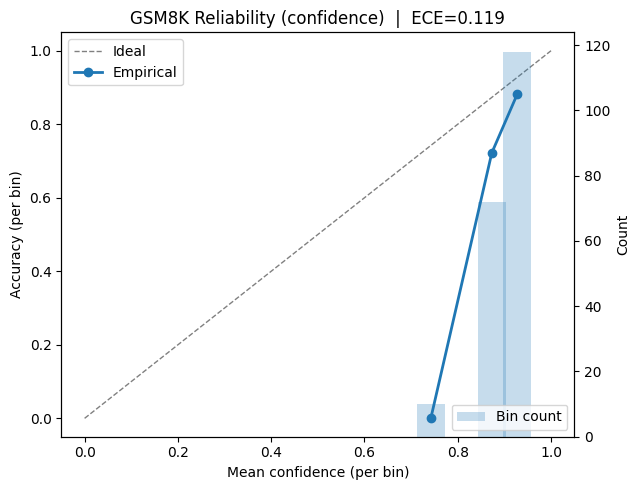

Items used: 200
ECE (10 bins): 0.1186
ECE value: 0.1186


In [28]:
ece_val = plot_reliability_confidence(df_gsm, conf_col="confidence", label_col="correct", 
                                      n_bins=10, title="GSM8K Reliability (confidence)")
print(f"ECE value: {ece_val:.4f}")


- Most predictions cluster at high confidence (0.9-1.0 bins dominate)
- The model is overconfident: the empirical accuracy curve sits below the y=x line in high-confidence bins.


Figure saved to visualization/GSM8K - AUROC by uncertainty method.jpeg


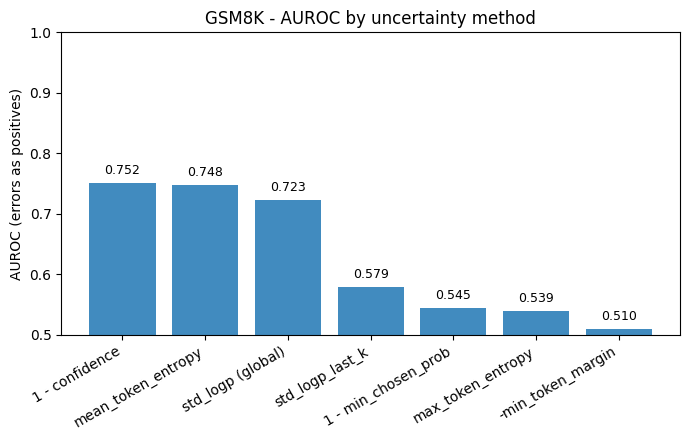

In [29]:
auroc_bar_chart(df_gsm,title="GSM8K - AUROC by uncertainty method")

Figure saved to visualization/GSM8K Error Detection ROC.jpeg


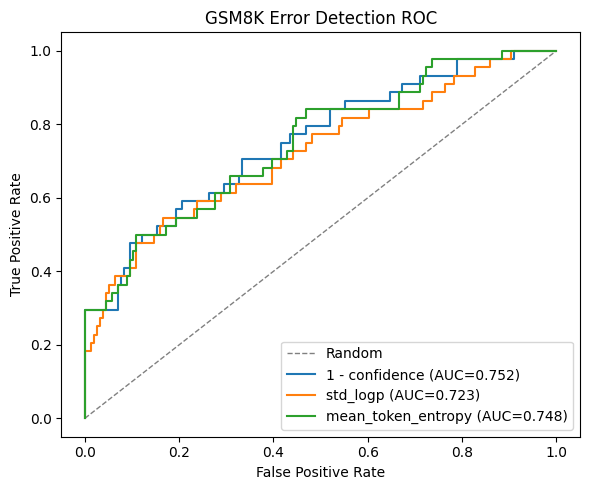

AUC 1 - confidence: 0.752
AUC std_logp: 0.723
AUC mean_token_entropy: 0.748


In [30]:
plot_roc_three(df_gsm, label_col="correct",title="GSM8K Error Detection ROC")

GSM8K - ROC curve :
Summary
- 1−confidence (0.752) and mean_token_entropy (0.748) are the top uncertainty signals and essentially tied

- std_logp (global) is competitive (0.723), while std_logp_last_k with K=10 underperforms (0.579)

- Single-token extremes (1−min_chosen_prob, max_token_entropy, −min_token_margin) are weak (0.51\~0.55)

Takeaways
- GSM8K errors are best ranked by overall certainty (confidence) or global dispersion (entropy)
- Tail-only variability underperforms because the ending is often deterministic (FINAL: ANSWER\nEND), which likely dampens last-K variability
- Bar chart ranks all methods by AUROC; the ROC with the top three shows 1−confidence and entropy overlapping and consistently above global std_logp across most FPR

Model evaluation for error detection
- AUROC  ≈0.75 indicates decent error detection—clearly better than random (0.5) but not yet strong (<0.8), leaving room for improvement

Implications
- Use 1−confidence or mean_token_entropy as the primary method for abstention 
- Keep std_logp (global) as a secondary, complementary feature


Figure saved to visualization/GSM8K mean_token_entropy vs correctness.jpeg


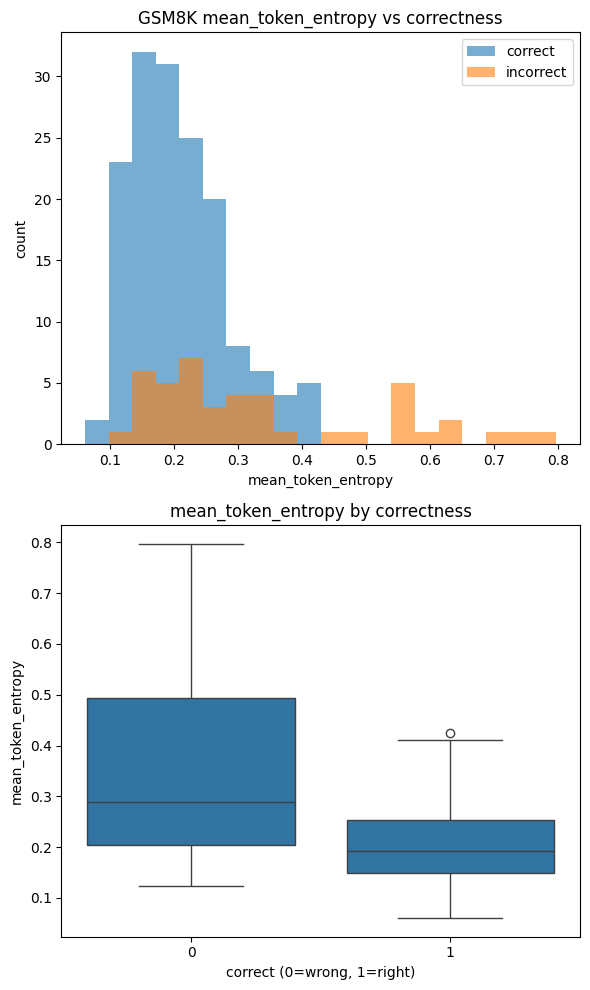

In [31]:
plot_hist_and_box_by_correct(df_gsm,title="GSM8K mean_token_entropy vs correctness")

GSM8K — mean_token_entropy analysis


- Incorrect answers show higher entropy and a wider spread. The wrong-class histogram is shifted right, with a long tail up to ≈0.8, while correct answers cluster around 0.1≈0.27

- Box plots indicate a higher median entropy for wrong answers (≈0.29) vs correct (≈0.20), and larger IQR for wrong -> more instability when the model errs

- There is overlap around 0.2≈0.3, so entropy isn’t perfectly discriminative (consistent with AUROC ≈ 0.75), but the shift is clear

Takeaway 
- Lower mean token entropy correlates with correctness
- Entropy is a strong uncertainty signal for GSM8K and supports using it alongside 1−confidence for selective prediction

Figure saved to visualization/GSM8K Risk coverage curve.jpeg


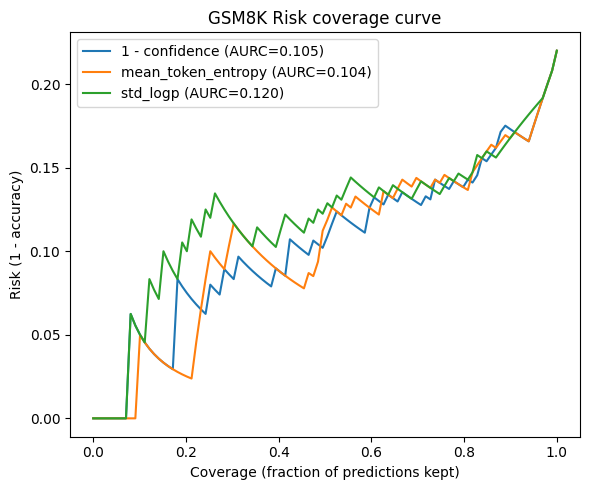

In [32]:
plot_risk_coverage(df_gsm,title="GSM8K Risk coverage curve")

GSM8K — Risk-Coverage Analysis

- Mean token entropy (AURC=0.104) and 1 - confidence (AURC=0.105) are the best-performing uncertainty measures, nearly tied
- Std_logp (AURC=0.120) underperforms slightly, indicating weaker error discrimination
- Overall, risk remains under 0.2 up to ~80% coverage, showing that selective prediction could meaningfully reduce errors  

Takeaway: 
- confidence and entropy are the most effective uncertainty signals for GSM8K selective prediction, while std_logp is less robust


Figure saved to visualization/GSM8K Feature distributions by correctness.jpeg


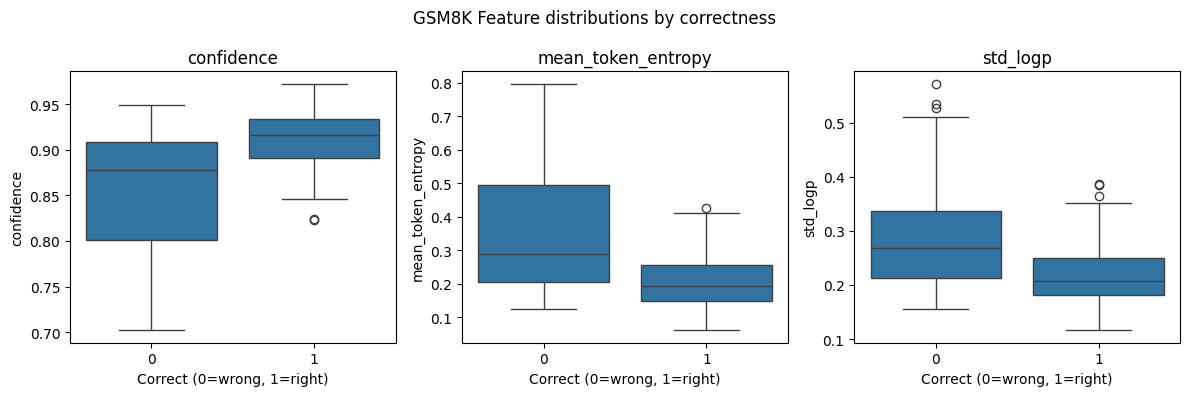

In [33]:
box_features_by_correct(df_gsm,title="GSM8K Feature distributions by correctness")

GSM8K - Feature distributions by correctness

- Confidence: Correct answers generally have higher confidence (median ≈0.92) than incorrect ones (median ≈0.87), though the overlap is substantial. This supports its role as a primary uncertainty signal

- Mean token entropy: Incorrect predictions show much higher entropy (median ≈0.29) and broader spread, while correct ones cluster lower (median ≈0.20). This separation reinforces entropy as a strong uncertainty measure

- Std logp: Similar to entropy, incorrect answers have higher dispersion of token log-probabilities, while correct ones stay tighter. The spread is less pronounced than entropy but still meaningful

Takeaway: 
- All three features distinguish correctness, with confidence and entropy showing the clearest separation. Std logp is supportive but less discriminative, which supports earlier analysis

Figure saved to visualization/GSM8K Uncertainty feature scatter.jpeg


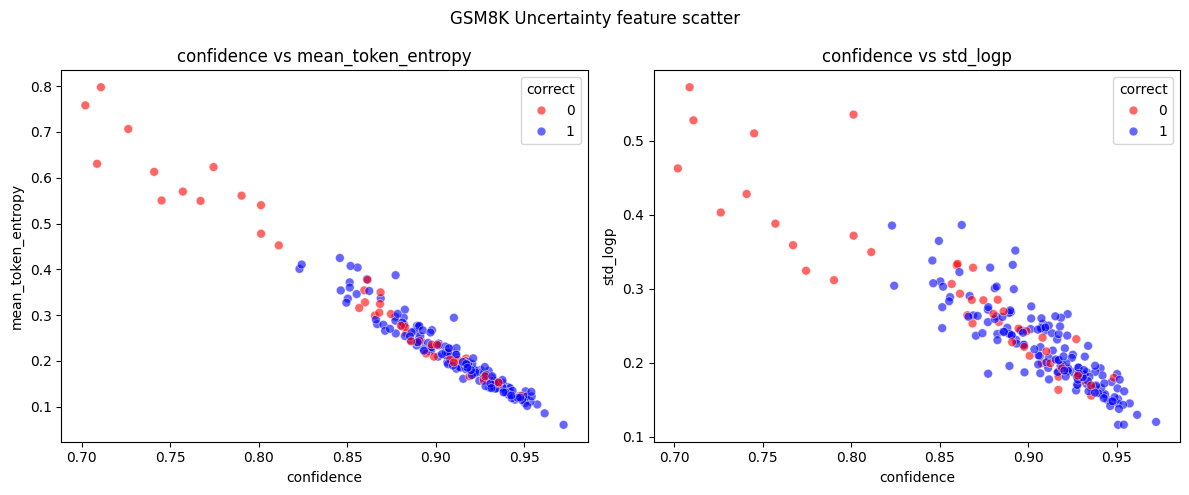

In [34]:
scatter_features_by_correct(df_gsm,title="GSM8K Uncertainty feature scatter")

GSM8K - Uncertainty Feature Scatter

- Confidence vs Mean Token Entropy\
Displays a strong inverse relationship: higher confidence corresponds to lower entropy. Incorrect predictions tend to cluster at the lower-confidence, higher-entropy end. However, there is still noticeable overlap, showing entropy alone is not a perfect separator

- Confidence vs Std Log-Prob\
A similar inverse trend appears: higher confidence aligns with lower variability in log-probs. Incorrect answers are more frequent at the high-variance, lower-confidence region. Overlaps slightly more than entropy did, displaying slightly less efficiency

Takeaway
- Confidence and mean token entropy are the strongest error-ranking signals overall, nearly tied in AUROC
- However, scatter plots reveal substantial overlap between correct and incorrect predictions, meaning they are not perfect separators at the individual prediction level
- Std log-prob is weaker than entropy, but still tracks uncertainty trends and can provide complementary signal

Figure saved to visualization/GSM8K Length effects on uncertainty signals.jpeg


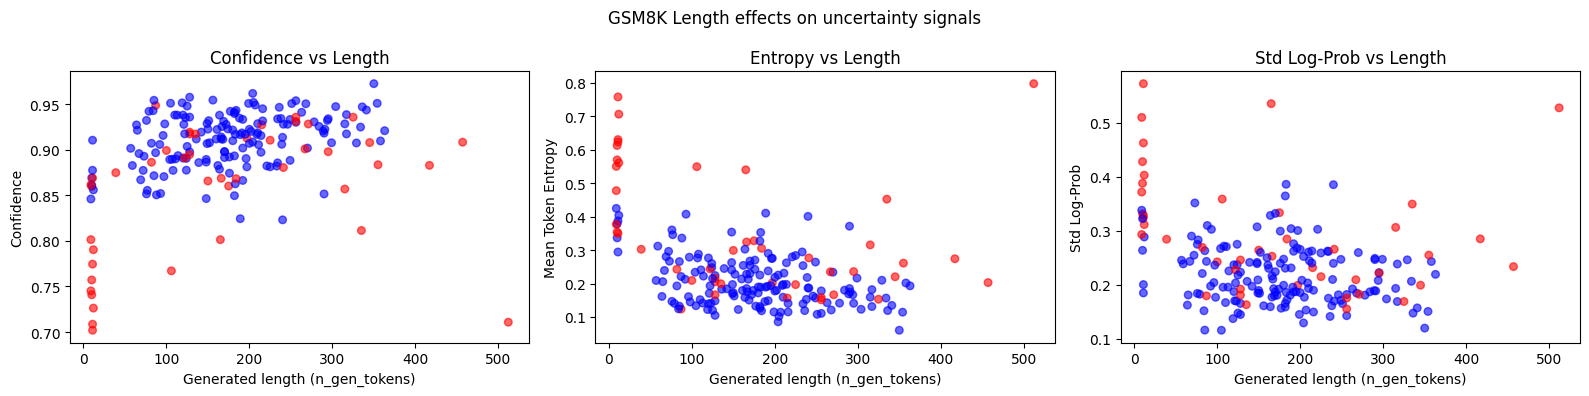

In [35]:
scatter_length_vs_uncertainties(df_gsm, title="GSM8K Length effects on uncertainty signals")

GSM8K - Length effects on uncertainty signals

- Confidence vs Length\
Confidence remains high across most lengths, with a cluster around 0-40 tokens where errors are more frequent. Beyond ~40 tokens, both correct and incorrect cases show similarly high confidence, suggesting confidence is not simply a function of length

- Entropy vs Length\
Mean token entropy decreases with length. Short generations (<50 tokens) show higher entropy and contain most of the errors. Longer sequences settle into lower entropy regardless of correctness, which reduces entropy’s discriminative power at higher lengths

- Std Log-Prob vs Length\
Variability in log-probs is elevated in shorter answers, especially for incorrect predictions. With increasing length, std_logp compresses toward lower values, but overlaps remain between correct and incorrect cases

Takeaway
- Uncertainty features are influenced by output length, particularly for short generations where errors are more common. However, beyond ~50 tokens, length effects diminish and features behave more consistently. This means length is a confounding factor for uncertainty, especially in GSM8K’s shorter outputs, and should be accounted for in evaluation

Figure saved to visualization/GSM8K Position-aware uncertainty.jpeg


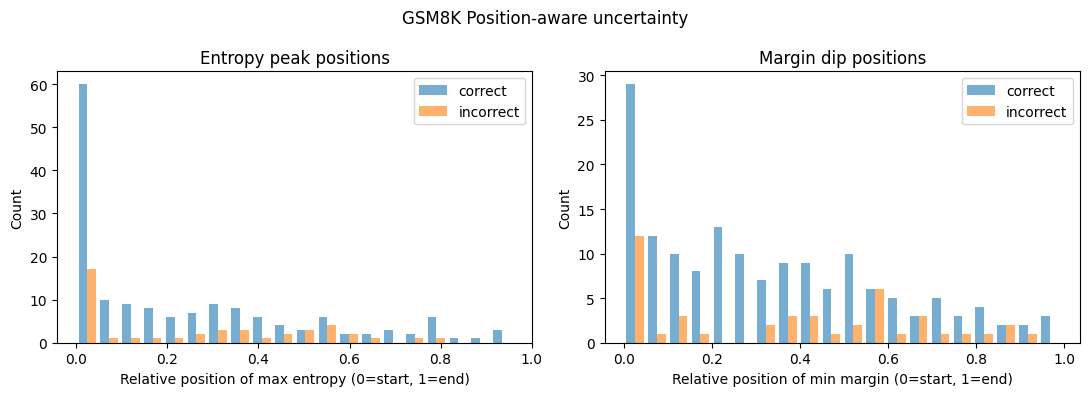

In [36]:
plot_position_uncertainty(df_gsm, title="GSM8K Position-aware uncertainty")

GSM8K - Position-aware Uncertainty

- Entropy peak positions
    - Max-entropy spikes are overwhelmingly concentrated near the start of the generation
    - Incorrect answers show slightly more scattered entropy peaks throughout the sequence, but the strongest mass remains at the beginning
    - This suggests the model resolves most uncertainty early, then stabilizes

- Margin dip positions
    - Min-margin (where the gap between top-1 and top-2 tokens is smallest) also clusters heavily near the start
    - Incorrect cases again show more spread across the sequence, with dips occasionally appearing mid-sequence
    - Correct outputs tend to keep margin dips earlier, suggesting more decisive token choices later in reasoning

Takeaway
- Uncertainty spikes occur disproportionately at the beginning of reasoning chains
- Later tokens, especially toward the final answer, are usually low-uncertainty and thus last-K metrics underperform
- For GSM8K, position-aware signals confirm that error detection should emphasize global measures (confidence, entropy) rather than tail-only variability

Figure saved to visualization/GSM8K Numeric error vs uncertainty.jpeg


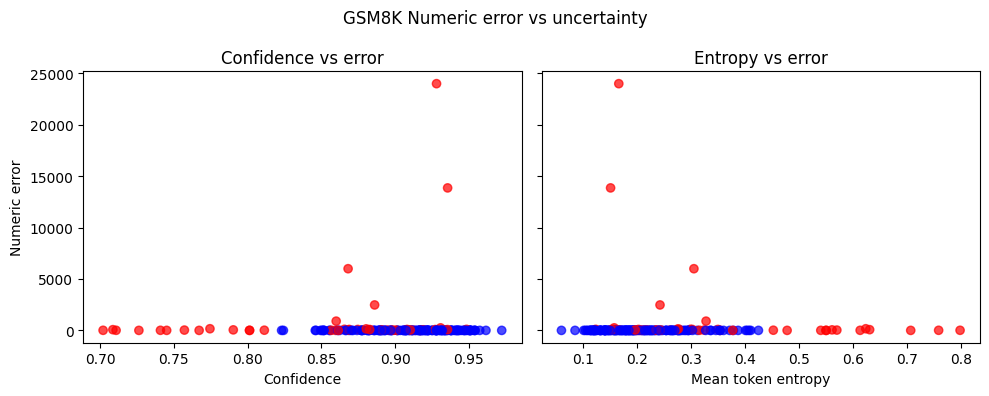

In [37]:
scatter_numeric_error(df_gsm)

GSM8K - Numeric error vs uncertainty

- Confidence vs error\
Most predictions are tightly clustered near zero error. However, when numeric error spikes occur, they are mostly concentrated in lower-confidence regions. Still, some large errors happen even at high confidence, showing that confidence is not a perfect safeguard against extreme mistakes<br><br>
- Entropy vs error\
Similarly, large errors are observed at low entropy, suggesting that even when the model appears certain, it can still produce severe miscalculations. Higher entropy cases tend to produce smaller but more frequent errors, while massive spikes happen under falsely low entropy

Takeaway
- Confidence and entropy generally track error rates (low confidence/high entropy -> more mistakes), but they do not prevent extreme outliers. The largest numeric errors occur precisely where uncertainty metrics suggest high certainty, highlighting calibration limits

In [38]:
def selective_accuracy_table(df, score_col="confidence", label_col="correct", coverages=[1.0, 0.9, 0.8, 0.7]):
    """
    Computes selective prediction accuracy at different coverage levels. 
    Coverage = fraction of data points retained.  
    Example: 90% coverage -> discard the 10% least confident predictions.
    If score_col is "confidence", it ranks by descending confidence.
    Otherwise, for uncertainty metrics, it ranks ascending (low uncertainty first).
    """
    labels = df[label_col].astype(float).values
    scores = pd.to_numeric(df[score_col], errors="coerce").astype(float).values

    # remove missing
    mask = np.isfinite(scores) & np.isfinite(labels)
    labels = labels[mask]
    scores = scores[mask]

    # determine ranking direction
    if score_col == "confidence":
        order = np.argsort(-scores)  # high to low
    else:
        order = np.argsort(scores)   # low uncertainty to high uncertainty

    labels_sorted = labels[order]
    n = len(labels_sorted)

    results = []
    for c in coverages:
        k = int(c * n)
        if k == 0: 
            continue
        acc = labels_sorted[:k].mean()
        results.append({"Coverage": f"{int(c*100)}%", "Accuracy": round(acc, 3)})

    return pd.DataFrame(results)

In [39]:
print("Selective accuracy with confidence")
display(selective_accuracy_table(df_gsm, score_col="confidence"))

print("\nSelective accuracy with mean_token_entropy")
display(selective_accuracy_table(df_gsm, score_col="mean_token_entropy"))

print("\nSelective accuracy with std_logp")
display(selective_accuracy_table(df_gsm, score_col="std_logp"))

Selective accuracy with confidence


,Coverage,Accuracy
0,100%,0.780
1,90%,0.828
2,80%,0.856
3,70%,0.871



Selective accuracy with mean_token_entropy


,Coverage,Accuracy
0,100%,0.780
1,90%,0.828
2,80%,0.862
3,70%,0.857



Selective accuracy with std_logp


,Coverage,Accuracy
0,100%,0.780
1,90%,0.828
2,80%,0.856
3,70%,0.857


GSM8K - Selective prediction

- At 100% coverage, overall accuracy is 78%

- When the lowest-confidence 10-20% of predictions are discarded, accuracy rises to 83-86%, showing that uncertainty estimates are useful for filtering unreliable answers

- At 70% coverage, accuracy is 86~87%, similar to the 80% level, suggesting the gains may be saturating. It is possible accuracy could increase further with heavier filtering, but discarding that much data is less practical

Comparison of signals

- Confidence and std_logp behave almost identically, with peak accuracy ~85-87%

- Mean token entropy slightly outperforms at 80% coverage (86.2%) but then dips, showing it is most effective for moderate abstention but less stable when filtering more aggressively

Takeaway
- Uncertainty estimates enable a reliability-coverage tradeoff. Accuracy can be boosted by selectively predicting only on the most confident 80-90% of cases, but aggressive filtering brings diminishing returns

### Case study on GSM8K data

In [40]:
def plot_token_series(probe, title="Token-level uncertainty"):
    H=np.array(probe["token_entropy"], float)
    M=np.array(probe["token_margin"], float)
    T=np.arange(len(H))

    plt.figure(figsize=(7,3.0))
    plt.plot(T, H, label="token entropy")
    plt.xlabel("token index"); plt.ylabel("entropy")
    plt.title(title); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,3.0))
    plt.plot(T, M)
    plt.xlabel("token index"); plt.ylabel("margin(p1-p2)")
    plt.title("Decisiveness across tokens"); plt.tight_layout(); plt.show()

def render_colored_tokens(probe, top_k=200):
    toks=probe["tokens"][:top_k]
    H=np.array(probe["token_entropy"][:top_k], float)
    if len(H) == 0:
        print("No tokens to render.")
        return
    norm=Normalize(vmin=np.min(H), vmax=np.max(H))
    cmap=plt.get_cmap("Reds")  # deeper red=higher entropy
    spans=[]
    for tok, h in zip(toks, H):
        color=cmap(norm(h))
        rgba=tuple(int(255*x) for x in color)
        hexcol="#{:02x}{:02x}{:02x}".format(rgba[0], rgba[1], rgba[2])
        spans.append(f"<span style='background-color:{hexcol}; padding:2px'>{tok}</span>")
    
    display(HTML("<div style='line-height:1.8; font-family:monospace'>" + " ".join(spans) + "</div>"))



In [41]:
# Casestudy 
@torch.no_grad()
def gsm8k_token_series(ex,system=None, chunk_size=128, max_total_new=512):

    q=ex["question"].strip()
    msgs=[]
    if system is not None:
        msgs.append({"role": "system", "content": system})
    msgs.append({"role": "user", "content": q})
    prompt_text=tok.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)
    enc=tok(prompt_text, return_tensors="pt")
    prompt_ids=enc.input_ids.to(model.device)      
    attn_mask =enc.attention_mask.to(model.device) 

           
    
    full_gen_ids=[]     
    chosen_lp=[]        # chosen token log prob
    entropies=[]        # entropy
    margins=[]          # p(top1)-p(top2) / margin of token selection
    toks=[]             
    total_new=0

    gen_buffer=''
    seen_final=False
    post_final_token_cap=40

    while total_new < max_total_new:
        out=model.generate(
            input_ids=prompt_ids,
            attention_mask=attn_mask,
            max_new_tokens=min(chunk_size, max_total_new - total_new),
            do_sample=False,
            pad_token_id=tok.pad_token_id,
            return_dict_in_generate=True,
            output_scores=True,
            use_cache=True,
        )

        full=out.sequences
        new_len=full.shape[1] - prompt_ids.shape[1]
        if new_len <= 0:
            break

        new_ids=full[:, -new_len:]              
        full_gen_ids.extend(new_ids[0].tolist())
        total_new += int(new_len)

        # per-token stats
        for t, logits in enumerate(out.scores):
            tid=new_ids[0, t].item()
            if tid == tok.eos_token_id:
                break
            logp=F.log_softmax(logits[0], dim=-1)
            p=logp.exp()
            top2, _=torch.topk(p, k=2)

            margins.append(float(top2[0].item() - top2[1].item()))
            chosen_lp.append(float(logp[tid].item()))
            entropies.append(float(-(p * logp).sum().item()))
            toks.append(tok.convert_ids_to_tokens([tid])[0])

        # early stop if prompt format ending is detected
        tail_text=tok.decode(new_ids[0], skip_special_tokens=True)
        gen_buffer=(gen_buffer + tail_text)[-256:] # prevent the buffer from becoming too large  
        final_=_final_re.search(gen_buffer)   
        if final_:
            seen_final=True
            tokens_after_final=0
            post_final=gen_buffer[final_.end():]
            if _end_re.search(post_final):   
                break

        if not seen_final:
            if _final_re.search(gen_buffer):
                seen_final=True
                tokens_after_final=0


        else:
            tokens_after_final += int(new_len)
            if _end_re.search(gen_buffer) or tokens_after_final >= post_final_token_cap:
                break

        # append generated tokens to prompt for chunk wise generation consistency
        prompt_ids=torch.cat([prompt_ids, new_ids], dim=1)
        attn_mask =torch.ones_like(prompt_ids, device=prompt_ids.device)

    gen_text=tok.decode(torch.tensor(full_gen_ids, device=model.device), skip_special_tokens=True) if full_gen_ids else ""

    return {
        "gen_text": gen_text,
        "tokens": toks,
        "token_entropy": entropies,
        "token_margin": margins,
        "chosen_logprobs": chosen_lp,
    }




In [42]:
def gsm8k_case_detail(row):
    item_id=row['id']
    system=(
        "You are a careful math solver. Be concise in your output.\n"
        "Let NUMBER be the numeric value of the quantity the question asks for (no units or symbols).\n"
        "Print the resulting number exactly in the format: FINAL: <NUMBER>\n"
        "Then on a new line write: END\n"
        "Do not output anything after END."
    )
    ex=gsm[item_id]
    
    out=gsm8k_token_series(ex,system=system)
    
    print("Question: ",ex['question'])
    print("Gold Answer: ",ex['answer'])
    print("\nLLM Answer: ",out['gen_text'])
    print("Correct: ",row['correct'])
    print("Model confidence: ",row['confidence'])
    
    plot_token_series(out, title=f"Token entropy over time (GSM8K item {item_id})")
    render_colored_tokens(out, top_k=512)
    

Question:  3 customers were kicked out of the Walmart for refusing to wear masks. A number equals to four times that many minus 5 were kicked out for shoplifting.  Three times the number of shoplifters were kicked out for physical violence over goods on sale. If a total of 50 people were kicked out of the Walmart, how many were kicked out for other reasons?
Gold Answer:  First quadruple the number of customers kicked out for not wearing masks: 4 * 3 customers = <<4*3=12>>12 customers
Then subtract 5 from this number: 12 customers - 5 customers = 7 customers
Then triple that number to find the number of people kicked out for violence: 7 customers * 3 = <<7*3=21>>21 customers
Then subtract the number of customers kicked out for each known reason to find the number kicked out for other reasons: 50 customers - 3 customers - 21 customers - 7 customers = <<50-3-21-7=19>>19 customers
#### 19

LLM Answer:  Let's denote the number of customers kicked out for refusing to wear masks as R. Accordi

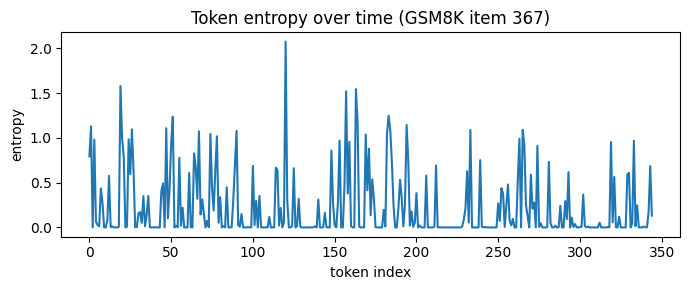

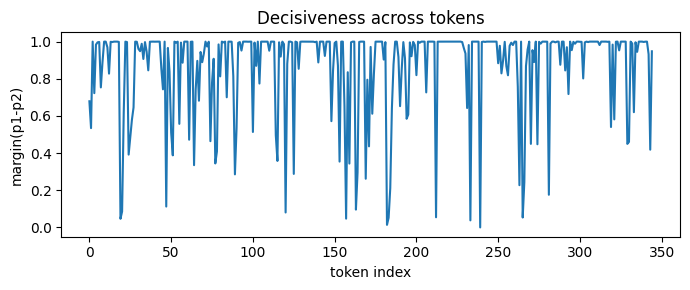

In [43]:
# row=df_gsm[(df_gsm['confidence']>0.9) & (df_gsm['correct']==0)].iloc[0,:]
row=df_gsm[df_gsm['id']==367].iloc[0,:]
gsm8k_case_detail(row)

### Case study: GSM8K item 367

Question:  
3 customers were kicked out of the Walmart for refusing to wear masks. A number equals to four times that many minus 5 were kicked out for shoplifting. Three times the number of shoplifters were kicked out for physical violence. If a total of 50 people were kicked out, how many were for other reasons?  

Gold Answer: 19  
LLM Answer: 40 (incorrect)  
Model confidence: 0.91  

Observations  
- The model carefully set up the equations but then mis-substituted when solving for the final count of “other reasons,” leading to an inflated result (40 instead of 19)
- Despite the logical slip, the model’s confidence was very high (~0.91), showing strong overconfidence in a wrong answer  
- Token-level plots highlight where uncertainty fluctuated:  
  - Entropy spikes occur around variable definitions and substitutions (“people”, “This total”, “We know that”), suggesting the model was less certain while structuring the reasoning steps
  - Margins remain high for most tokens, showing decisiveness, but with occasional sharp drops at key logical transitions  
- The heatmap shows highest uncertainty concentrated on “people,” “This total,” and “We know that,” reinforcing that the model struggles most at structuring and summing constraints  

Takeaways  
- In this case the error arises not from step-by-step arithmetic but from mishandling substitutions or totals
- High global confidence masks local uncertainty spikes, demonstrating why calibration is challenging in reasoning tasks 
- Token-level signals (entropy spikes, margin dips) reveal local uncertainty during reasoning transitions, even though the final answer was delivered with strong confidence

## TriviaQA Dataset

In [44]:
trivia=load_dataset("trivia_qa", "rc", split="validation[:2000]") 
print("Loaded TriviaQA examples:", len(trivia))
print(trivia[0].keys())   

Loaded TriviaQA examples: 2000
dict_keys(['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'])


In [45]:
embedder=SentenceTransformer("all-MiniLM-L6-v2")
def normalize_answer(s):
    #Lowercase, remove punctuation/articles/extra whitespace 
    def remove_articles(text):
        return re.sub(r"\b(a|an|the)\b", " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        return re.sub(r"[^a-z0-9 ]+", "", text)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))



def f1_score(prediction, ground_truth):
    # Token level F1 score
    pred_tokens=normalize_answer(prediction).split()
    gold_tokens=normalize_answer(ground_truth).split()
    if not pred_tokens or not gold_tokens:
        return 0.0
    common=set(pred_tokens) & set(gold_tokens)
    if not common:
        return 0.0
    prec=len(common) / len(pred_tokens)
    rec =len(common) / len(gold_tokens)
    return 2 * prec * rec / (prec + rec)

def cosine_score(pred_text, golds):
    # cosine similarity for sementic comparison
    if not pred_text:
        return 0.0
    emb_pred=embedder.encode(pred_text, convert_to_tensor=True, normalize_embeddings=True)
    emb_golds=embedder.encode(golds, convert_to_tensor=True, normalize_embeddings=True)
    sims=util.cos_sim(emb_pred, emb_golds)[0]
    return float(torch.max(sims).item())


In [46]:
def triviaqa_output_parser(ex, gen_text):
    
    pred_text=gen_text.strip() if gen_text else ""
    if not pred_text:
        return pred_text, 0.0, 0.0, 0.0, 0.0, None

    
    golds=[ex["answer"]["value"]] + ex["answer"].get("aliases", [])
    golds_norm=[normalize_answer(g) for g in golds]
    pred_norm=normalize_answer(pred_text)

    matched_gold=None # ground truth alias best matched with prediction

    # exact match
    if pred_norm in golds_norm:
        em=1.0
        matched_gold=golds[golds_norm.index(pred_norm)]
    else:
        em=0.0

    # containment - determines if any ground truth alias is present in LLM output
    contain=0.0
    pred_tokens=pred_norm.split()
    for i, g in enumerate(golds_norm):
        if not g:
            continue
        gold_tokens=g.split()
        
        for j in range(len(pred_tokens) - len(gold_tokens) + 1):
            if pred_tokens[j:j+len(gold_tokens)] == gold_tokens:
                contain=1.0
                if matched_gold is None:
                    matched_gold=golds[i]
                break
        if contain == 1.0:
            break

    # Token level F1 score 
    f1_scores=[f1_score(pred_text, g) for g in golds]
    best_idx=int(max(range(len(f1_scores)), key=lambda i: f1_scores[i]))
    f1=f1_scores[best_idx]
    if matched_gold is None:
        matched_gold=golds[best_idx]

    # Cosine similarity
    cosine=cosine_score(pred_text, golds)

    return pred_text, em, contain, f1, cosine, matched_gold


In [47]:
def triviaqa_eval(dataset, n=50, system="Answer the question concisely with only the main fact.",
                     seed=42, chunk_size=64, max_total_new=64):
   
    rng=np.random.default_rng(seed)
    idxs=rng.permutation(len(dataset))[:n]

    rows=[]
    for i, idx in enumerate(idxs, 1):
        ex=dataset[int(idx)]

        out=generate_response(ex,data_type="qa",system=system,chunk_size=chunk_size,max_total_new=max_total_new)

        # comparison criteria
        pred_text, em, contain, f1, cosine, matched_gold=triviaqa_output_parser(ex, out["gen_text"])

        row={
            
            "id": int(idx),
            "question": ex["question"],
            "gold_answer": ex["answer"]["value"],
            "gold_aliases": ex["answer"].get("aliases", []),
            "matched_gold": matched_gold,
            "pred_text": pred_text,
            "gen_text": out["gen_text"],
            "em": float(em),                 
            "contain": float(contain),       
            "f1": float(f1),                 
            "cosine": float(cosine),         
            "confidence": out["confidence"],
            "mean_token_entropy": out["mean_token_entropy"],
            "max_token_entropy": out["max_token_entropy"],
            "argmax_token_entropy": out["argmax_token_entropy"],
            "min_token_margin": out["min_token_margin"],
            "argmin_token_margin": out["argmin_token_margin"],
            "min_chosen_prob": out["min_chosen_prob"],
            "argmin_chosen_prob": out["argmin_chosen_prob"],
            "std_logp":out["std_logp"],
            "std_logp_last_k": out["std_logp_last_k"],
            "n_prompt_tokens": out["n_prompt_tokens"],
            "n_gen_tokens": out["n_gen_tokens"],
        }
        rows.append(row)

        if i % 10 == 0:
            print(f"[{i}/{len(idxs)}] done")

    df=pd.DataFrame(rows)
    return df

In [48]:
system=(
    "You are a factual QA assistant.\n"
    "Return ONLY the answer span (a short phrase).\n"
    "No explanations, no punctuation, no quotes, no extra words, no newlines.\n"
    "If you are unsure, output: unknown"
)

df_trivia=triviaqa_eval(trivia, n=500, system=system, seed=42)
# store to csv for easy access
run_id = time.strftime("%Y%m%d-%H%M%S")
trivia_csv_name=f'triviaqa_phi3_{run_id}.csv'
df_trivia.to_csv(trivia_csv_name,header=True,index=False)

C:\ProgramData\anaconda3\envs\jpai\lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


[10/500] done
[20/500] done
[30/500] done
[40/500] done
[50/500] done
[60/500] done
[70/500] done
[80/500] done
[90/500] done
[100/500] done
[110/500] done
[120/500] done
[130/500] done
[140/500] done
[150/500] done
[160/500] done
[170/500] done
[180/500] done
[190/500] done
[200/500] done
[210/500] done
[220/500] done
[230/500] done
[240/500] done
[250/500] done
[260/500] done
[270/500] done
[280/500] done
[290/500] done
[300/500] done
[310/500] done
[320/500] done
[330/500] done
[340/500] done
[350/500] done
[360/500] done
[370/500] done
[380/500] done
[390/500] done
[400/500] done
[410/500] done
[420/500] done
[430/500] done
[440/500] done
[450/500] done
[460/500] done
[470/500] done
[480/500] done
[490/500] done
[500/500] done


In [49]:

# load TriviaQA output from save file. 
df_trivia=pd.read_csv(trivia_csv_name)

'''  Please uncomment the following code block if pre-existing dataset is to be examined '''
# notebook_dir = os.path.dirname(os.path.abspath("__file__"))
# trivia_csv_path=os.path.join(notebook_dir,'output_csv','triviaqa_phi3_500.csv')
# try:
#     df_trivia=pd.read_csv(trivia_csv_path)
# except Exception as e:
#     print(f"Error reading {trivia_csv_path}: {e}")


'  Please uncomment the following code block if pre-existing dataset is to be examined '

In [50]:
df_trivia.head(3)

,id,question,gold_answer,gold_aliases,matched_gold,pred_text,gen_text,em,contain,f1,...,max_token_entropy,argmax_token_entropy,min_token_margin,argmin_token_margin,min_chosen_prob,argmin_chosen_prob,std_logp,std_logp_last_k,n_prompt_tokens,n_gen_tokens
0,1631,What is the first name of Ragnor’s brother in ...,Rollo,"['Gångerolf', 'Rollo', 'Rollo Ragnavaldson', '...",Rollo,Unknown,Unknown,0.0,0.0,0.000000,...,4.216446,0,0.045833,0,0.146568,0,0.889297,0.889297,81,3
1,285,"What were Benjy and Laska, which were sent int...",Mice,"['🐁', 'Mouse subgenus', 'Reproductive behavior...",Mice,Unknown,Unknown,0.0,0.0,0.000000,...,4.184502,0,0.197542,0,0.307009,0,0.547538,0.547538,78,3
2,1268,Limburger cheese is made from the milk of whic...,Cow,"['🐄', 'Wild Bull', 'Moo unit', 'Cattle anatomy...",Cows,Limburger cheese is made from the milk of cows.,Limburger cheese is made from the milk of cows.,0.0,1.0,0.222222,...,1.276239,0,0.059981,7,0.510460,7,0.185869,0.029879,70,14


## Visualization and analysis
Before we proceed with visualization and analysis, let’s perform a case study. With the TriviaQA dataset, deciding on what counts as “correct” is not trivial. We have four candidate metrics:

- EM (Exact Match): Binary [0,1]. Requires prediction to exactly match a gold answer string. Very strict; penalizes semantically correct but differently phrased answers<br><br>

- Contain: Binary [0,1]. Checks if any gold alias appears as a contiguous span in the prediction. Forgiving — captures partial matches (“New York City” vs “New York”) but can also over-credit irrelevant matches<br><br>

- F1: Token-level overlap [0~1]. Gives partial credit and works well when answers are short (as is common in TriviaQA). Often balances between EM’s harshness and Contain’s generosity<br><br>

- Cosine similarity: Continuous [0~1]. Embedding-based semantic similarity, robust to paraphrasing. Useful for analysis but less interpretable as a correctness label for calibration or ROC<br><br>

### Case study

In [51]:
@torch.no_grad()
def triviaqa_token_series(ex, system="Answer concisely.", max_new_tokens=64):
   
    msgs = []
    if system is not None:
        msgs.append({"role": "system", "content": system})
    msgs.append({"role": "user", "content": ex["question"].strip()})
    prompt_text = tok.apply_chat_template(msgs, tokenize=False, add_generation_prompt=True)


    enc = tok(prompt_text, return_tensors="pt")
    prompt_ids = enc.input_ids.to(model.device)
    attn_mask = enc.attention_mask.to(model.device)


    out = model.generate(
        input_ids=prompt_ids,
        attention_mask=attn_mask,
        max_new_tokens=max_new_tokens,
        do_sample=False,                     
        pad_token_id=tok.pad_token_id,
        return_dict_in_generate=True,
        output_scores=True,
        use_cache=True,
    )

    # collect token stats
    full = out.sequences
    new_ids = full[:, prompt_ids.shape[1]:]        

    toks, entropies, margins, chosen_lp = [], [], [], []
    for t, logits in enumerate(out.scores):
        tid = new_ids[0, t].item()
        if tid == tok.eos_token_id:
            break
        logp = F.log_softmax(logits[0], dim=-1)
        p = logp.exp()
        top2, _ = torch.topk(p, k=2)

        toks.append(tok.convert_ids_to_tokens([tid])[0])
        chosen_lp.append(float(logp[tid].item()))
        entropies.append(float(-(p * logp).sum().item()))
        margins.append(float(top2[0].item() - top2[1].item()))

    gen_text = tok.decode(new_ids[0], skip_special_tokens=True)

    return {
        "gen_text": gen_text,
        "tokens": toks,
        "token_entropy": entropies,
        "token_margin": margins,
        "chosen_logprobs": chosen_lp,
    }

In [52]:
def trivia_case_details(row):
    item_id=row['id']
    system=(
        "You are a factual QA assistant.\n"
        "Return ONLY the answer span (a short phrase).\n"
        "No explanations, no punctuation, no quotes, no extra words, no newlines.\n"
        "If you are unsure, output: unknown"
    )
    
    ex=trivia[item_id]
    print("Question: ",ex['question'])
    print("Gold answer: ",ex['answer']['value'])
    print("Gold aliases: ",ex['answer']['aliases'])
    out=triviaqa_token_series(ex, system=system, max_new_tokens=64)
    print("\nLLM Answer: ",out['gen_text'])
    print("EM: ",row['em'])
    print("Contain: ",row['contain'])
    print("F1: ",row['f1'])
    print("Cosine similarity: ",row['cosine'])
    print("Model confidence: ",row['confidence'])
    
    plot_token_series(out, title=f"Token entropy over time (Trivia item {item_id})")
    render_colored_tokens(out, top_k=200)

Question:  Limburger cheese is made from the milk of which animal?
Gold answer:  Cow
Gold aliases:  ['🐄', 'Wild Bull', 'Moo unit', 'Cattle anatomy', 'Female cattle', 'Domesticated cattle', 'Domestic cow', "Cow's size", 'Empalo', 'Moo-cow', 'Bos taurus domesticus', '🐮', 'Moo cow', 'Domestic cattle', 'Bovine animal', 'Bos primigenius taurus', 'Cow', 'Bull-calf', 'Bos taurus', 'Beeves', 'Domestic Cattle', 'Anatomy of cattle', 'Cattle herding', 'Male cattle', 'Wild bull', 'B. taurus', 'Bos Taurus', 'Cattle slaughter', 'Cattle', 'Cows', 'Feral cattle']

LLM Answer:  Limburger cheese is made from the milk of cows.
EM:  0.0
Contain:  1.0
F1:  0.2222222222222222
Cosine similarity:  0.4392253756523132
Model confidence:  0.903965120973084


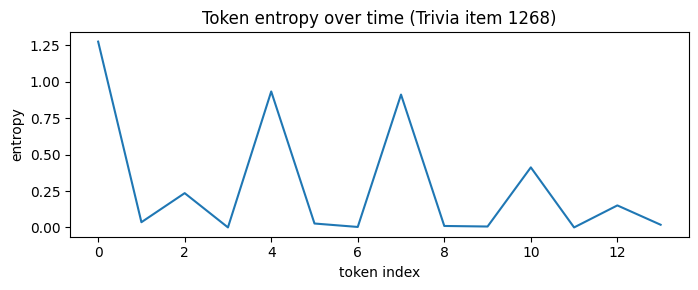

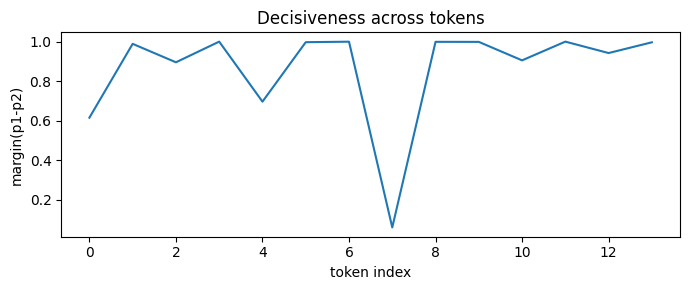

In [53]:
# Case study 1
item_idx=0 
# row=df_trivia[(df_trivia['em']==0) & (df_trivia['contain']==1)].iloc[item_idx,:]
row=df_trivia[df_trivia['id']==1268].iloc[item_idx,:]
trivia_case_details(row)

### Case study: TriviaQA item 1268
- Question: Limburger cheese is made from the milk of which animal?
- Gold answer: Cow
- Gold aliases: includes Cow, Cows, Domestic cow, Domesticated cattle, Bos taurus, etc
- LLM answer: Limburger cheese is made from the milk of cows.

Evaluation metrics

- EM = 0
- Contain = 1
- F1 ≈ 0.22
- Cosine similarity ≈ 0.44

Why EM and F1 are low

- The prediction contains the correct alias (cows), but surrounded by a full sentence.
- EM requires an exact string match, so the extra words prevent credit.
- F1 is depressed because only 1 token (cows) overlaps out of many predicted tokens.
- Contain gives credit since the alias cows appears verbatim.
- Cosine gives partial similarity, reflecting the right semantics but diluted by sentence length.

Token-level uncertainty

- Entropy and margin show high confidence on the answer token cows
- Spikes in entropy/margin dips occur on function words like the
- Model is not uncertain about the answer itself, only about phrasing

Takeaways

- EM underestimates correctness when the model outputs a sentence instead of a short span
- F1 also undervalues correctness in span-vs-sentence mismatches; however for smaller word count F1 would be good
- Contain better captures correctness in this case
- Token-level uncertainty supports that the model was confident about the true answer

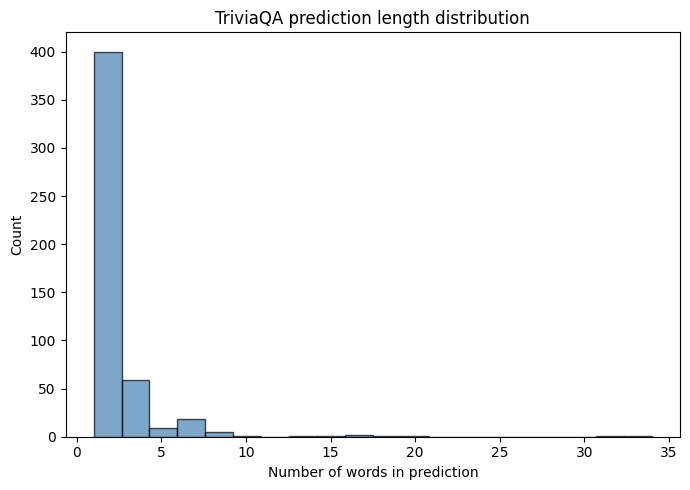

In [54]:
# compute word counts in LLM prediction
df_trivia["pred_len"] = df_trivia["pred_text"].fillna("").str.split().str.len()


plt.figure(figsize=(7,5))
plt.hist(df_trivia["pred_len"], bins=20, color="steelblue", alpha=0.7, edgecolor="black")
plt.xlabel("Number of words in prediction")
plt.ylabel("Count")
plt.title("TriviaQA prediction length distribution")
plt.tight_layout()
plt.show()

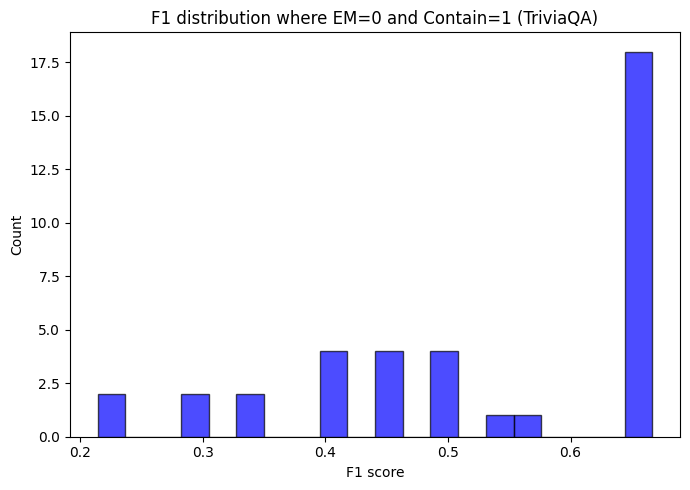

Number of cases: 38
Mean F1 in this subset: 0.532


In [55]:
subset = df_trivia[(df_trivia["em"] == 0) & (df_trivia["contain"] == 1)]

plt.figure(figsize=(7,5))
plt.hist(subset["f1"], bins=20, color="blue", alpha=0.7, edgecolor="black")
plt.xlabel("F1 score")
plt.ylabel("Count")
plt.title("F1 distribution where EM=0 and Contain=1 (TriviaQA)")
plt.tight_layout()
plt.show()

print(f"Number of cases: {len(subset)}")
print(f"Mean F1 in this subset: {subset['f1'].mean():.3f}")

Metric choice for TriviaQA

Evaluating correctness on TriviaQA requires care, since model outputs are often short spans but occasionally full sentences. This creates systematic differences across metrics.

Case analysis

- When EM=0 but Contain=1, the F1 distribution shows partial overlap scores in the 0.2-0.65 range
- These cases occur because the model outputs a full sentence 
- EM assigns 0, underestimating correctness
- F1 provides partial recovery, but its ceiling is low due to sentence length penalties
- Contain consistently captures correctness, since the gold alias is present in the prediction

Takeaways

- EM is overly strict and systematically underestimates correctness
- F1 gives partial credit, but still undervalues correct answers when extra words are present
- Contain is the most faithful correctness metric for this task
- We therefore adopt Contain as the primary correctness measure for TriviaQA, while reporting EM and F1 alongside it for comparability with standard QA benchmarks

In [56]:
metrics=calculate_metrics(df_trivia,method='confidence',label='contain')
print("Metric summary based on confidence -")
for i in metrics.keys():
    print(i,'score \t:',metrics[i])

Metric summary based on confidence -
accuracy score 	: 0.43
brier score 	: 0.2447442649683349
ece score 	: 0.2616106473145009
auroc score 	: 0.8342717258261934


Metric summary (TriviaQA, confidence vs contain)

- Accuracy ≈ 0.43 (less than half matches with gold answer)
- Brier score ≈ 0.245 -> relatively high probability error, showing that predicted confidences often diverge from true correctness
- ECE ≈ 0.262 -> strong miscalibration; confidence values overestimate correctness
- AUROC ≈ 0.834 -> despite miscalibration, uncertainty signals rank errors well

Takeaways
- The model is overconfident: confidence values are systematically higher than accuracy
- Calibration quality is poor (high ECE), meaning raw probabilities should not be interpreted as correctness likelihood
- However, AUROC shows that uncertainty still separates correct from incorrect answers, so it can be used for ranking or abstention strategies

Figure saved to visualization/TriviaQA Reliability (confidence).jpeg


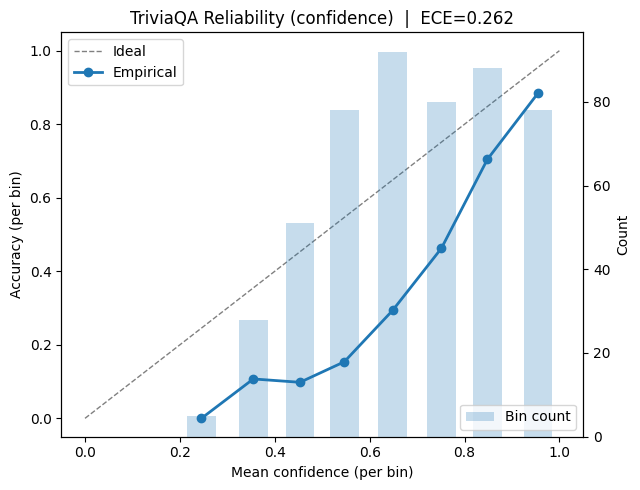

Items used: 500
ECE (10 bins): 0.2616


In [57]:
ece_val = plot_reliability_confidence(df_trivia, conf_col="confidence", label_col="contain", 
                                      n_bins=10, title="TriviaQA Reliability (confidence)")

- ECE = 0.262, indicating notable miscalibration
- The curve lies below the diagonal across most bins -> the model is quite overconfident
- Predictions in the 0.8-1.0 confidence range achieve ≈0.7-0.9 accuracy, not the near-perfect levels suggested
- Lower confidence bins (0.2-0.5) are especially poorly calibrated, with accuracy close to zero despite non-trivial confidence scores
- The histogram shows predictions cluster in the mid-to-high confidence range, so miscalibration directly affects most outputs

Takeaways

- Model confidence does not reliably reflect correctness
- Overconfidence is the dominant trend, particularly harmful since most predictions lie in high-confidence bins
- ECE of ≈0.26 confirms poor calibration

Figure saved to visualization/TriviaQA - AUROC by uncertainty method.jpeg


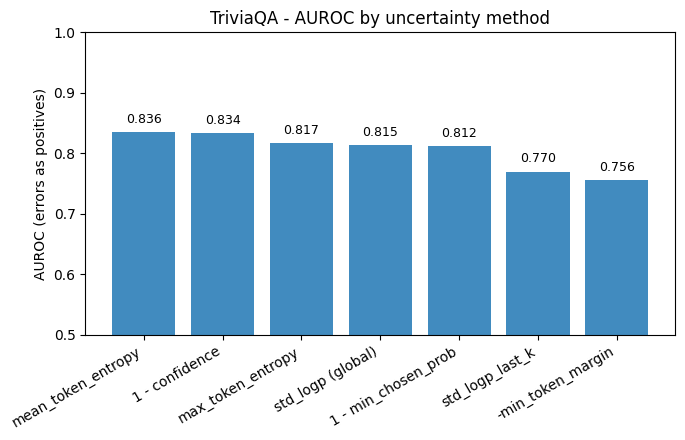

In [58]:
auroc_bar_chart(df_trivia,label_col="contain",title="TriviaQA - AUROC by uncertainty method")

Figure saved to visualization/TriviaQA Error Detection ROC.jpeg


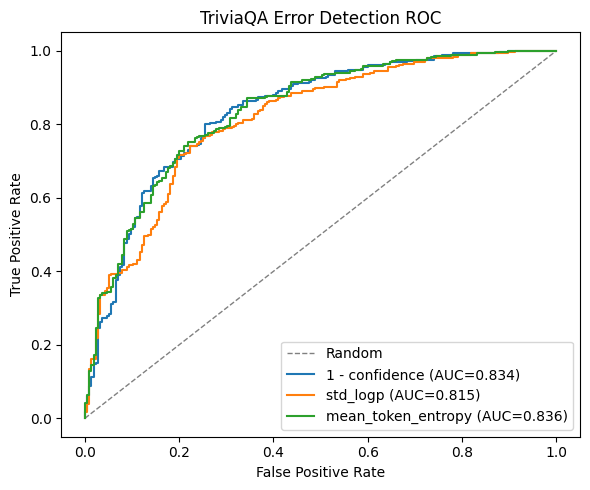

AUC 1 - confidence: 0.834
AUC std_logp: 0.815
AUC mean_token_entropy: 0.836


In [59]:
plot_roc_three(df_trivia, label_col="contain",title="TriviaQA Error Detection ROC")

AUROC summary
- Mean token entropy: 0.836 (best)
- 1 − confidence: 0.834 (almost identical to entropy)
- Std logp (global): 0.815
- Other measures perform reasonably but are less effective, especially local token-level features

ROC curves

- All top methods are well above the random baseline
- Mean token entropy and 1 − confidence overlap almost perfectly, showing strong reliability as error detectors
- Std logp trails slightly behind but still provides a useful signal (AUC ≈0.82)

Takeaways
- TriviaQA error detection is robust, with multiple methods above AUROC 0.80
- Confidence and mean token entropy are the most reliable, with nearly identical performance
- Std logp provides a weaker but still useful signal
- Local token-level methods (margin dips, last-k statistics) are less effective

Figure saved to visualization/TriviaQA mean_token_entropy vs correctness.jpeg


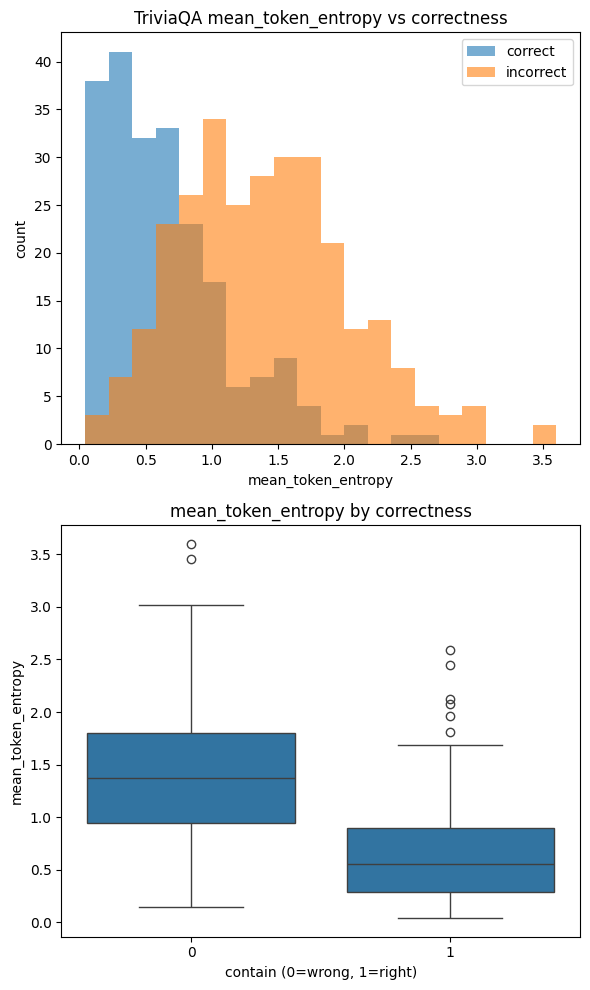

In [60]:
plot_hist_and_box_by_correct(df_trivia,label_col="contain",title="TriviaQA mean_token_entropy vs correctness")

Feature analysis: mean token entropy (TriviaQA)

Histogram

- Correct predictions cluster at low entropy values (0~0.8)
- Incorrect predictions are shifted to higher entropy (1.0~2.0+)
- The overlap region (0.5~1.2) indicates cases where entropy alone is less decisive

Boxplot

- Median entropy for correct answers is ≈0.5
- Median entropy for incorrect answers is ≈1.4
- Distribution spread is wider for incorrect predictions, with more high-entropy outliers

Takeaways

- Mean token entropy is a strong separator between correct and incorrect predictions
- Low entropy reliably indicates correctness, while high entropy is strongly associated with errors
- Supports the AUROC results: entropy is among the top-performing uncertainty signals in TriviaQA

Figure saved to visualization/TriviaQA Risk coverage curve.jpeg


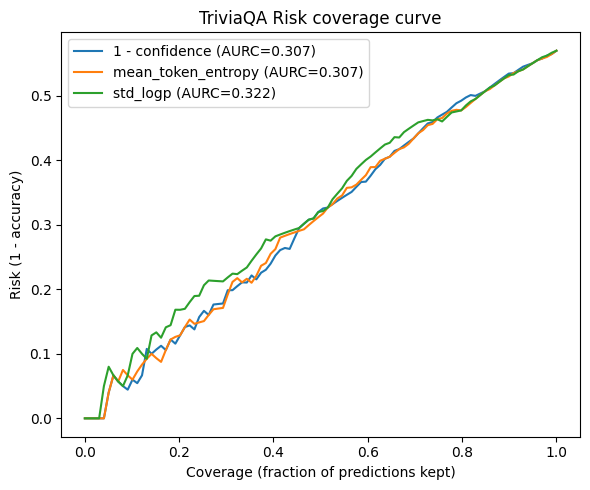

In [61]:
plot_risk_coverage(df_trivia,label_col="contain",title="TriviaQA Risk coverage curve")


Risk-coverage analysis (TriviaQA)

- AURC values are low: confidence (0.307), entropy (0.307), std logp (0.322)  
- Curves are close to diagonal, showing weak selectivity  
- Accuracy does not improve sharply when abstaining on low-confidence answers  
- Suggests TriviaQA is a harder setting for uncertainty-based abstention compared to GSM8K  
- Uncertainty still separates errors (AUROC > 0.8), but risk-coverage highlights the difficulty of using abstention alone for reliability  

Figure saved to visualization/TriviaQA Feature distributions by correctness.jpeg


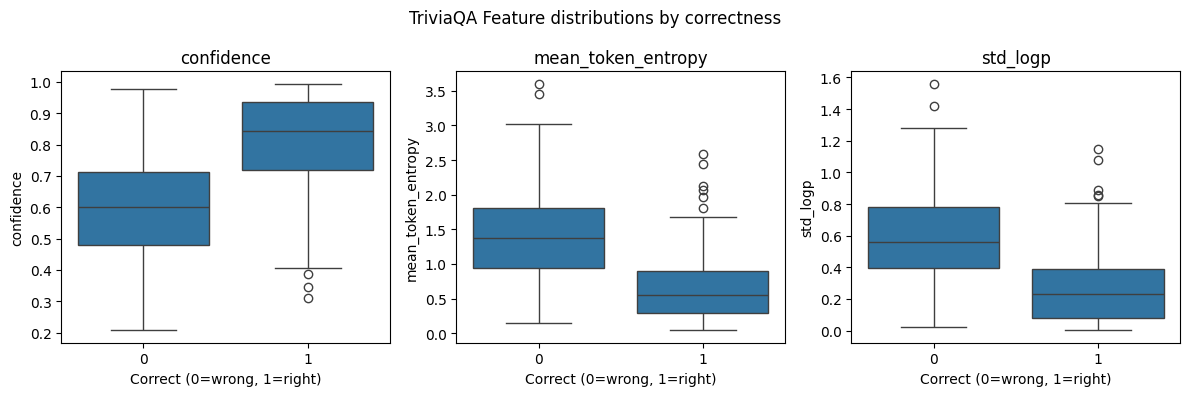

In [62]:
box_features_by_correct(df_trivia,label_col="contain",title="TriviaQA Feature distributions by correctness")


Feature distributions by correctness (TriviaQA)

Confidence

- Correct predictions -> high median confidence ≈0.85

- Incorrect predictions -> lower median ≈0.6, with wider spread

- Clear separation, though some overlap remains

Mean token entropy

- Correct -> low entropy (median ≈0.5)

- Incorrect -> higher entropy (median ≈1.4), with more outliers above 3.0

- Strong separation, consistent with earlier histogram/box analysis

Std logp

- Correct -> narrow distribution around ≈0.25

- Incorrect -> broader, higher spread (median ≈0.6)

- Some overlap, but still indicative of correctness differences<br><br>

Takeaways

- All three signals (confidence, entropy, std logp) separate correct from incorrect predictions

- Confidence and entropy are the most reliable indicators

- Std logp contributes a weaker but still useful signal

- Reinforces AUROC and ROC results: global measures outperform local fluctuations

Figure saved to visualization/TriviaQA Uncertainty feature scatter.jpeg


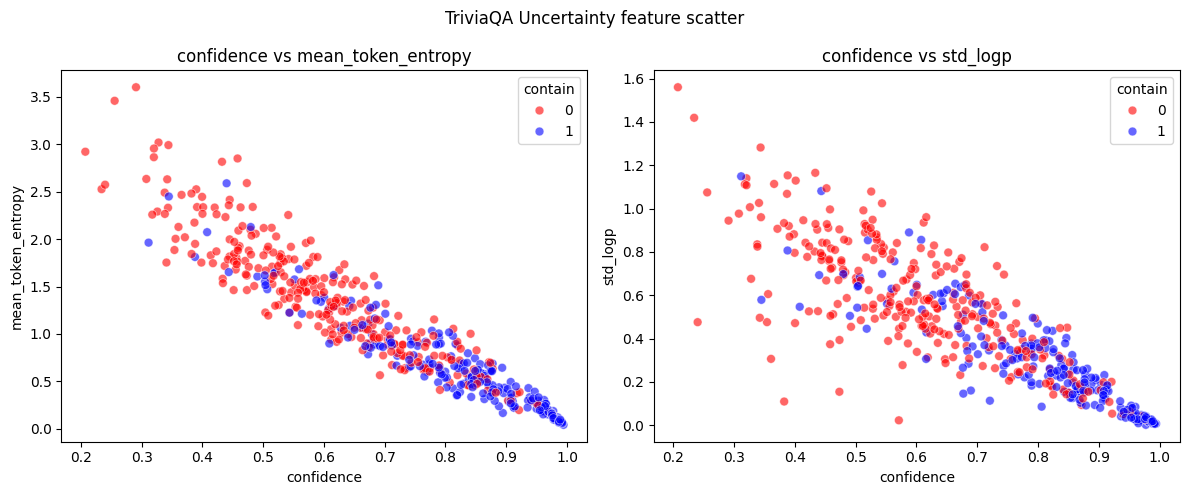

In [63]:
scatter_features_by_correct(df_trivia,label_col="contain",title="TriviaQA Uncertainty feature scatter")


Uncertainty feature scatter (TriviaQA)

Confidence vs mean token entropy

- Strong inverse relationship: higher confidence corresponds to lower entropy

- Correct predictions (blue) cluster tightly at high confidence + low entropy

- Incorrect predictions (red) spread out in low confidence + high entropy region

- Clear separation line, showing both features capture the same uncertainty signal

Confidence vs std logp

- Negative correlation: lower confidence aligns with higher std logp

- Correct answers group near high confidence, low std logp

- Incorrect answers spread out with low confidence, high std logp

- Separation is weaker than with entropy, consistent with AUROC results<br><br>

Takeaways

- Confidence, entropy, and std logp are redundant but mutually reinforcing uncertainty signals

- Correct predictions consistently appear in the high-confidence, low-uncertainty zone

- Incorrect predictions dominate the low-confidence, high-uncertainty zone, confirming that uncertainty features are reliable error indicators

## Skipped analyses for TriviaQA

- **Length effects**: Unlike GSM8K, TriviaQA answers are short spans (mostly 1-3 words).  
  Output length does not vary meaningfully, so uncertainty is not influenced by sequence length.  
  Length-based analysis is therefore skipped.  

- **Selective prediction table**: Risk-coverage curves already show weak selectivity (AURC ≈0.31).  
  A tabular breakdown of accuracy vs coverage would not provide additional insights, since abstention does not significantly improve accuracy in this setting.  
  This step is skipped to avoid redundancy.  

# Cross-dataset summary and conclusions

We evaluated uncertainty quantification across two distinct task types: GSM8K (math reasoning) and TriviaQA (factual QA). This provided a contrast between structured, multi-step reasoning outputs and short factual span answers.

## Key findings

- **Calibration**
  - GSM8K: Accuracy ≈0.78, Brier ≈0.17, ECE ≈0.12 -> moderately calibrated, but still overconfident
  - TriviaQA: Accuracy ≈0.43, Brier ≈0.24, ECE ≈0.26 -> much poorer calibration, stronger overconfidence

- **Error detection (AUROC)**
  - GSM8K: Inverse confidence AUROC ≈0.75 -> uncertainty can rank errors well, but imperfect
  - TriviaQA: Inverse confidence AUROC ≈0.83, mean entropy AUROC ≈0.84 -> strong separation of correct vs incorrect
  - Global sequence-level signals (confidence, mean token entropy) consistently outperform token-local ones (margins, last-k std logp)

- **Risk-coverage (selective prediction)**
  - GSM8K: Risk-coverage curves show abstention improves performance (AURC reduction), supporting selective prediction
  - TriviaQA: Curves are nearly diagonal, abstention provides little gain
  - Indicates abstention is more useful for structured reasoning tasks than short factual QA

- **Feature analysis**
  - GSM8K: Numeric error correlates with higher entropy and lower confidence
  - TriviaQA: Correct predictions cluster at high confidence + low entropy, incorrect ones at the reverse
  - Entropy is a consistent signal across both tasks

- **Length and position**
  - GSM8K: Longer outputs show higher uncertainty; position-aware plots reveal spikes at reasoning bottlenecks
  - TriviaQA: Outputs are short (1-3 tokens); length and position features add little

## Overall conclusions

- **Best-performing methods**
  - Confidence is the strongest and simplest estimator across both tasks, AUROC ≈0.75 (GSM8K), ≈0.83 (TriviaQA)
  - Mean entropy provides a slight edge in TriviaQA (AUROC ≈0.84) but is less intuitive for deployment
  - Local features (margins, last-k std logp) are weaker and noisier

- **Task differences**
  - GSM8K benefits more from selective prediction, making abstention strategies effective
  - TriviaQA shows stronger AUROC but weak selective potential, highlighting the need for calibration rather than abstention
  
- **Knowledge limitations in factual QA**  
  - In TriviaQA, uncertainty is less reliable because the model’s factual recall depends on its internal knowledge base  
  - The model can be *highly confident yet wrong* when the correct fact is absent from its parameters - a form of **confident ignorance**  
  - This limits the usefulness of uncertainty for detecting factual gaps, though it remains valuable for understanding overconfidence and calibration  
  - Future extensions could combine **retrieval-augmented generation (RAG)** or **external verification** with uncertainty estimation to improve factual reliability  

- **Limitations**
  - Both datasets show systematic overconfidence (Brier >0.15, ECE >0.1)
  - Local token-level features add little value compared to aggregated global signals
  - Short-span QA (TriviaQA) is less amenable to abstention

Uncertainty quantification is effective at ranking errors across both math and factual QA, but its practical utility depends on task type:
- For math reasoning (GSM8K), abstention and risk-coverage strategies are promising
- For factual QA (TriviaQA), calibration methods are more important to make confidence scores trustworthy
- Sampling-based uncertainty estimation (e.g., multiple generations or dropout ensembles) could enhance calibration and robustness, particularly for factual QA tasks such as TriviaQA, where confidence signals are reliable but poorly calibrated.


## References

- **GSM8K** - Cobbe et al., ["Training Verifiers to Solve Math Word Problems"](https://arxiv.org/abs/2110.14168)
- **TriviaQA** - Joshi et al., ["TriviaQA: A Large Scale Distantly Supervised Challenge Dataset for Reading Comprehension"](https://arxiv.org/abs/1705.03551)